In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

pd.set_option('display.max_columns', None)

In [7]:
data_base = pd.read_csv("application.csv")

data = data_base.sample(frac=0.1, random_state=123)

In [8]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [9]:
data.describe(include='all')

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,13672,10284.000000,10284,10284,10284,10284,10284.000000,1.028400e+04,1.028400e+04,10283.000000,1.026900e+04,10230,10284,10284,10284,10284,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,3487.000000,10284.0,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,7019,10284.000000,10284.000000,10284.000000,10284,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284,4475.000000,10266.000000,8251.000000,3742.000000,3131.00000,3943.000000,2601.000000,2327.000000,3540.000000,3763.000000,3816.000000,2507.000000,3070.000000,2435.000000,3839.000000,2344.000000,3383.000000,3742.000000,3131.000000,3943.000000,2601.000000,2327.000000,3540.000000,3763.000000,3816.000000,2507.000000,3070.000000,2435.000000,3839.000000,2344.000000,3383.000000,3742.000000,3131.000000,3943.000000,2601.000000,2327.000000,3540.000000,3763.000000,3816.000000,2507.000000,3070.000000,2435.000000,3839.000000,2344.000000,3383.000000,2428,3805,4004.000000,3657,4119,10249.000000,10249.000000,10249.000000,10249.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.0,10284.000000,10284.0,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,10284.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000,8887.000000
unique,13672,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,6,7,5,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [10]:
for i in data.columns: 
        print(data[i].value_counts())
        print()


SK_ID_CURR
298944    1
363630    1
431440    1
400377    1
405222    1
         ..
425339    1
398413    1
315132    1
433675    1
444749    1
Name: count, Length: 13672, dtype: int64

TARGET
0.0    9440
1.0     844
Name: count, dtype: int64

NAME_CONTRACT_TYPE
Cash loans         9307
Revolving loans     977
Name: count, dtype: int64

CODE_GENDER
F    6814
M    3470
Name: count, dtype: int64

FLAG_OWN_CAR
N    6795
Y    3489
Name: count, dtype: int64

FLAG_OWN_REALTY
Y    7014
N    3270
Name: count, dtype: int64

CNT_CHILDREN
0.0    7189
1.0    2038
2.0     894
3.0     155
4.0       8
Name: count, dtype: int64

AMT_INCOME_TOTAL
135000.0    1189
112500.0    1047
157500.0     860
180000.0     828
90000.0      815
            ... 
258750.0       1
192163.5       1
391972.5       1
223200.0       1
300150.0       1
Name: count, Length: 282, dtype: int64

AMT_CREDIT
450000.0     341
675000.0     311
225000.0     289
180000.0     246
270000.0     242
            ... 
422505.0       1
1408909

In [11]:
low_var_cols = []

for col in data.columns:
    top_freq = data[col].dropna().value_counts(normalize=True).max()

    if top_freq >= 0.98:
        low_var_cols.append(col)

print("Drop olunacaq sütunlar:", low_var_cols)

data = data.drop(columns=low_var_cols)


Drop olunacaq sütunlar: ['FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'REG_REGION_NOT_LIVE_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']


In [12]:
missing_percent = (data.isnull().sum() / len(data)) * 100

missing_percent = missing_percent[missing_percent > 0]

for col, percent in missing_percent.items():
    print(f"{col}: {percent:.2f}%")


TARGET: 24.78%
NAME_CONTRACT_TYPE: 24.78%
CODE_GENDER: 24.78%
FLAG_OWN_CAR: 24.78%
FLAG_OWN_REALTY: 24.78%
CNT_CHILDREN: 24.78%
AMT_INCOME_TOTAL: 24.78%
AMT_CREDIT: 24.78%
AMT_ANNUITY: 24.79%
AMT_GOODS_PRICE: 24.89%
NAME_TYPE_SUITE: 25.18%
NAME_INCOME_TYPE: 24.78%
NAME_EDUCATION_TYPE: 24.78%
NAME_FAMILY_STATUS: 24.78%
NAME_HOUSING_TYPE: 24.78%
REGION_POPULATION_RELATIVE: 24.78%
DAYS_BIRTH: 24.78%
DAYS_EMPLOYED: 24.78%
DAYS_REGISTRATION: 24.78%
DAYS_ID_PUBLISH: 24.78%
OWN_CAR_AGE: 74.50%
FLAG_EMP_PHONE: 24.78%
FLAG_WORK_PHONE: 24.78%
FLAG_PHONE: 24.78%
FLAG_EMAIL: 24.78%
OCCUPATION_TYPE: 48.66%
CNT_FAM_MEMBERS: 24.78%
REGION_RATING_CLIENT: 24.78%
REGION_RATING_CLIENT_W_CITY: 24.78%
WEEKDAY_APPR_PROCESS_START: 24.78%
HOUR_APPR_PROCESS_START: 24.78%
REG_REGION_NOT_WORK_REGION: 24.78%
REG_CITY_NOT_LIVE_CITY: 24.78%
REG_CITY_NOT_WORK_CITY: 24.78%
LIVE_CITY_NOT_WORK_CITY: 24.78%
ORGANIZATION_TYPE: 24.78%
EXT_SOURCE_1: 67.27%
EXT_SOURCE_2: 24.91%
EXT_SOURCE_3: 39.65%
APARTMENTS_AVG: 72.63%
BA

In [13]:
def clean_data(data, target_col='TARGET', id_col='SK_ID_CURR', null_threshold=50):
    
    # 1. Remove rows where the target is missing
    initial_rows = data.shape[0]
    data = data.dropna(subset=[target_col])
    print(f"{initial_rows - data.shape[0]} rows removed due to missing target values.")
    
    # 2. Drop the identifier column if it exists
    if id_col in data.columns:
        data = data.drop(columns=[id_col])
        print(f"Dropped column: {id_col}")
    
    # 3. Drop columns exceeding the missing value threshold
    dropped_cols = [col for col in data.columns if data[col].isnull().mean() * 100 > null_threshold]
    if dropped_cols:
        data = data.drop(columns=dropped_cols)
        print("Dropped columns with >{0}% missing values: {1}".format(null_threshold, dropped_cols))
    else:
        print("No columns exceeded the missing value threshold.")
    
    # 4. Fill remaining missing values
    count_cols = [
        'OBS_30_CNT_SOCIAL_CIRCLE',
        'DEF_30_CNT_SOCIAL_CIRCLE',
        'OBS_60_CNT_SOCIAL_CIRCLE',
        'DEF_60_CNT_SOCIAL_CIRCLE',
        'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY',
        'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON',
        'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR'
    ]

    unknown_cols = [
        'OCCUPATION_TYPE'
    ]

    for col in data.columns:
        if col in count_cols:
            data[col].fillna(0, inplace=True)
        elif col in unknown_cols:
            data[col].fillna('Unknown', inplace=True)
        elif data[col].dtype == object:
            data[col].fillna(data[col].mode()[0], inplace=True)
        else:
            data[col].fillna(data[col].mean(), inplace=True)
    
    return data

data = clean_data(data)


3388 rows removed due to missing target values.
Dropped column: SK_ID_CURR
Dropped columns with >50% missing values: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONL

C:\Users\user\AppData\Local\Temp\ipykernel_25316\3264736247.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_25316\3264736247.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [14]:
for col in data.columns:
    if data[col].nunique() == 1:
        print(f"{col}: {data[col].unique()}")
        data.drop(columns=[col], inplace=True)

In [15]:
data.isnull().sum()

TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
REG_REGION

In [16]:
data.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                6
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
dtype: int64

In [17]:
print(data['ORGANIZATION_TYPE'].value_counts(dropna=False).to_string())

ORGANIZATION_TYPE
Business Entity Type 3    2220
XNA                       1895
Self-employed             1300
Other                      548
Medicine                   402
Government                 358
School                     325
Business Entity Type 2     315
Trade: type 7              303
Kindergarten               251
Construction               233
Business Entity Type 1     209
Transport: type 4          176
Trade: type 3              114
Industry: type 9           111
Industry: type 3           109
Security                   100
Housing                     96
Agriculture                 84
Bank                        83
Military                    81
Industry: type 11           75
Police                      73
Transport: type 2           68
Postal                      67
Restaurant                  66
Trade: type 2               64
Security Ministries         58
Services                    48
Industry: type 7            45
University                  43
Industry: type 1     

In [18]:

organization_to_group = {
  
    'Business Entity Type 1': 'Business / Corporate',
    'Business Entity Type 2': 'Business / Corporate',
    'Business Entity Type 3': 'Business / Corporate',
    'Self-employed': 'Business / Corporate',

    
    'Trade: type 1': 'Trade & Services',
    'Trade: type 2': 'Trade & Services',
    'Trade: type 3': 'Trade & Services',
    'Trade: type 4': 'Trade & Services',
    'Trade: type 5': 'Trade & Services',
    'Trade: type 6': 'Trade & Services',
    'Trade: type 7': 'Trade & Services',
    'Services': 'Trade & Services',
    'Restaurant': 'Trade & Services',
    'Hotel': 'Trade & Services',
    'Cleaning': 'Trade & Services',
    'Realtor': 'Trade & Services',
    'Advertising': 'Trade & Services',

    
    'Industry: type 1': 'Industry / Manufacturing',
    'Industry: type 2': 'Industry / Manufacturing',
    'Industry: type 3': 'Industry / Manufacturing',
    'Industry: type 4': 'Industry / Manufacturing',
    'Industry: type 5': 'Industry / Manufacturing',
    'Industry: type 6': 'Industry / Manufacturing',
    'Industry: type 7': 'Industry / Manufacturing',
    'Industry: type 8': 'Industry / Manufacturing',
    'Industry: type 9': 'Industry / Manufacturing',
    'Industry: type 10': 'Industry / Manufacturing',
    'Industry: type 11': 'Industry / Manufacturing',
    'Industry: type 12': 'Industry / Manufacturing',
    'Industry: type 13': 'Industry / Manufacturing',
    'Construction': 'Industry / Manufacturing',
    'Electricity': 'Industry / Manufacturing',

    
    'School': 'Education',
    'Kindergarten': 'Education',
    'University': 'Education',

    
    'Medicine': 'Health / Medicine',

    
    'Government': 'Government / Public Sector',
    'Police': 'Government / Public Sector',
    'Military': 'Government / Public Sector',
    'Security': 'Government / Public Sector',
    'Security Ministries': 'Government / Public Sector',
    'Emergency': 'Government / Public Sector',
    'Postal': 'Government / Public Sector',

    
    'Bank': 'Finance & Insurance',
    'Insurance': 'Finance & Insurance',

    
    'Telecom': 'Telecom / Mobile',
    'Mobile': 'Telecom / Mobile',

    
    'Culture': 'Culture & Religion',
    'Religion': 'Culture & Religion',

    
    'Housing': 'Housing / Misc',

    
    'XNA': 'Other',
    'Other': 'Other'
}
def map_organization_to_group(org_type):
  
    if org_type in organization_to_group:
        return organization_to_group[org_type]
    else:
    
        organization_to_group[org_type] = 'Other'
        return 'Other'


data['organization_group'] = data['ORGANIZATION_TYPE'].apply(map_organization_to_group)


In [19]:
data['OCCUPATION_TYPE'].value_counts(dropna=False)

OCCUPATION_TYPE
Unknown                  3265
Laborers                 1753
Sales staff              1115
Core staff                906
Managers                  701
Drivers                   655
High skill tech staff     359
Medicine staff            311
Accountants               304
Cooking staff             219
Security staff            212
Cleaning staff            155
Private service staff      97
Low-skill Laborers         75
Secretaries                44
Waiters/barmen staff       41
Realty agents              33
IT staff                   24
HR staff                   15
Name: count, dtype: int64

In [20]:
occupation_to_group = {
    'Laborers': 'Manual Labor',
    'Low-skill Laborers': 'Manual Labor',
    'Cleaning staff': 'Manual Labor',
    'Cooking staff': 'Manual Labor',
    'Security staff': 'Manual Labor',
    'Drivers': 'Manual Labor',

    'Sales staff': 'Sales & Service',
    'Realty agents': 'Sales & Service',
    'Waiters/barmen staff': 'Sales & Service',
    'Private service staff': 'Sales & Service',

    'Core staff': 'Professional / Skilled',
    'High skill tech staff': 'Professional / Skilled',
    'IT staff': 'Professional / Skilled',
    'Medicine staff': 'Professional / Skilled',

    'Accountants': 'Finance / Accounting',

    'Managers': 'Management',
    'HR staff': 'Management',

    'Secretaries': 'Administrative Support',

    'Unknown': 'Other' 
}

def map_occupation_to_group(occupation):
    if occupation in occupation_to_group:
        return occupation_to_group[occupation]
    else:
        return 'Other'  

data['occupation_group'] = data['OCCUPATION_TYPE'].apply(map_occupation_to_group)


In [21]:
data['credit_to_income'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['is_large_family'] = (data['CNT_FAM_MEMBERS'] > 4).astype(int)
data['is_single_parent'] = ((data['CNT_CHILDREN'] > 0) & (data['NAME_FAMILY_STATUS'].isin(['Single / not married','Separated','Widow']))).astype(int)
data['age_years'] = np.floor(-data['DAYS_BIRTH'] / 365.25).astype(int)

In [22]:
data.drop(['DAYS_BIRTH','OCCUPATION_TYPE','ORGANIZATION_TYPE'], axis=1, inplace=True)


In [23]:
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,organization_group,occupation_group,credit_to_income,is_large_family,is_single_parent,age_years
871,1.0,Cash loans,F,N,N,0.0,90000.0,450000.0,21888.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-4815.0,-6556.0,-4295.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,TUESDAY,13.0,0.0,0.0,0.0,0.0,0.326084,0.511970,0.0,0.0,0.0,0.0,-1101.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Manual Labor,5.000000,0,0,33
30216,0.0,Cash loans,M,Y,Y,0.0,157500.0,277969.5,16087.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020246,-2468.0,-2563.0,-3968.0,1.0,1.0,1.0,0.0,2.0,3.0,3.0,TUESDAY,8.0,0.0,0.0,0.0,0.0,0.506491,0.191822,0.0,0.0,0.0,0.0,-2295.0,0.0,0.0,1.0,2.0,1.0,1.0,Industry / Manufacturing,Manual Labor,1.764886,0,0,31
71525,0.0,Cash loans,F,N,Y,0.0,180000.0,1205451.0,39969.0,1080000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.015221,-621.0,-8237.0,-1166.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,WEDNESDAY,11.0,0.0,0.0,0.0,0.0,0.717858,0.358951,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Finance / Accounting,6.696950,0,0,38
34743,1.0,Cash loans,M,N,Y,0.0,225000.0,528633.0,39654.0,472500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-241.0,-7233.0,-2184.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,FRIDAY,14.0,1.0,1.0,0.0,0.0,0.378102,0.504681,0.0,0.0,0.0,0.0,-317.0,1.0,0.0,0.0,0.0,0.0,9.0,Government / Public Sector,Manual Labor,2.349480,0,0,51
126024,0.0,Cash loans,F,N,N,0.0,180000.0,450000.0,22977.0,450000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.008019,-211.0,-7942.0,-1813.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,SATURDAY,17.0,0.0,0.0,0.0,0.0,0.471828,0.511970,0.0,0.0,0.0,0.0,-534.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Professional / Skilled,2.500000,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119433,0.0,Cash loans,F,N,N,0.0,90000.0,127350.0,12726.0,112500.0,Unaccompanied,State servant,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-758.0,-11203.0,-644.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,SUNDAY,15.0,0.0,0.0,0.0,0.0,0.449437,0.511970,1.0,0.0,1.0,0.0,-473.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Manual Labor,1.415000,0,0,46
88911,0.0,Cash loans,F,N,Y,0.0,135000.0,509922.0,36396.0,472500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,365243.0,-14120.0,-4282.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,THURSDAY,16.0,0.0,0.0,0.0,0.0,0.742715,0.819318,2.0,1.0,2.0,1.0,-3019.0,1.0,0.0,0.0,0.0,0.0,4.0,Other,Other,3.777200,0,0,61
106379,0.0,Cash loans,F,N,Y,0.0,112500.0,277969.5,10606.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.031329,-499.0,-4865.0,-484.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,1.0,1.0,0.0,0.424992,0.424130,4.0,0.0,4.0,0.0,-1785.0,1.0,0.0,0.0,0.0,1.0,0.0,Trade & Services,Sales & Service,2.470840,0,0,30
26

In [24]:
data_lr = data.copy()
data_knn = data.copy()
data_rf_xgb_lgb_cb = data.copy()
data_cbc = data.copy()


In [25]:
#logistic Regression

In [26]:
data_lr

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,organization_group,occupation_group,credit_to_income,is_large_family,is_single_parent,age_years
871,1.0,Cash loans,F,N,N,0.0,90000.0,450000.0,21888.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-4815.0,-6556.0,-4295.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,TUESDAY,13.0,0.0,0.0,0.0,0.0,0.326084,0.511970,0.0,0.0,0.0,0.0,-1101.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Manual Labor,5.000000,0,0,33
30216,0.0,Cash loans,M,Y,Y,0.0,157500.0,277969.5,16087.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020246,-2468.0,-2563.0,-3968.0,1.0,1.0,1.0,0.0,2.0,3.0,3.0,TUESDAY,8.0,0.0,0.0,0.0,0.0,0.506491,0.191822,0.0,0.0,0.0,0.0,-2295.0,0.0,0.0,1.0,2.0,1.0,1.0,Industry / Manufacturing,Manual Labor,1.764886,0,0,31
71525,0.0,Cash loans,F,N,Y,0.0,180000.0,1205451.0,39969.0,1080000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.015221,-621.0,-8237.0,-1166.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,WEDNESDAY,11.0,0.0,0.0,0.0,0.0,0.717858,0.358951,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Finance / Accounting,6.696950,0,0,38
34743,1.0,Cash loans,M,N,Y,0.0,225000.0,528633.0,39654.0,472500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-241.0,-7233.0,-2184.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,FRIDAY,14.0,1.0,1.0,0.0,0.0,0.378102,0.504681,0.0,0.0,0.0,0.0,-317.0,1.0,0.0,0.0,0.0,0.0,9.0,Government / Public Sector,Manual Labor,2.349480,0,0,51
126024,0.0,Cash loans,F,N,N,0.0,180000.0,450000.0,22977.0,450000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.008019,-211.0,-7942.0,-1813.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,SATURDAY,17.0,0.0,0.0,0.0,0.0,0.471828,0.511970,0.0,0.0,0.0,0.0,-534.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Professional / Skilled,2.500000,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119433,0.0,Cash loans,F,N,N,0.0,90000.0,127350.0,12726.0,112500.0,Unaccompanied,State servant,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-758.0,-11203.0,-644.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,SUNDAY,15.0,0.0,0.0,0.0,0.0,0.449437,0.511970,1.0,0.0,1.0,0.0,-473.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Manual Labor,1.415000,0,0,46
88911,0.0,Cash loans,F,N,Y,0.0,135000.0,509922.0,36396.0,472500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,365243.0,-14120.0,-4282.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,THURSDAY,16.0,0.0,0.0,0.0,0.0,0.742715,0.819318,2.0,1.0,2.0,1.0,-3019.0,1.0,0.0,0.0,0.0,0.0,4.0,Other,Other,3.777200,0,0,61
106379,0.0,Cash loans,F,N,Y,0.0,112500.0,277969.5,10606.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.031329,-499.0,-4865.0,-484.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,1.0,1.0,0.0,0.424992,0.424130,4.0,0.0,4.0,0.0,-1785.0,1.0,0.0,0.0,0.0,1.0,0.0,Trade & Services,Sales & Service,2.470840,0,0,30
26

In [27]:
epsilon = 1e-4

for var in data_lr.columns:
    if var == 'TARGET':
        continue

    if data_lr[var].dtype != object:

        q1 = data_lr[var].quantile(0.25)
        q2 = data_lr[var].quantile(0.5)
        q3 = data_lr[var].quantile(0.75)

        ranges = [-np.inf, q1, q2, q3, np.inf]
        data_lr['category_' + var] = pd.cut(data_lr[var], bins=ranges, duplicates='drop')

        grouped = data_lr.groupby(['category_' + var, 'TARGET'])['TARGET'].count().unstack().fillna(0).reset_index()

        grouped['positive_prop'] = grouped.get(0, 0) / grouped.get(0, 0).sum()
        grouped['negative_prop'] = grouped.get(1, 0) / grouped.get(1, 0).sum()

        grouped['positive_prop'] = grouped['positive_prop'].replace(0, epsilon)
        grouped['negative_prop'] = grouped['negative_prop'].replace(0, epsilon)

        grouped['woe'] = np.log(grouped['positive_prop'] / grouped['negative_prop'])

        grouped.rename(columns={'woe': var + '_woe'}, inplace=True)

        data_lr = data_lr.merge(grouped[['category_' + var, var + '_woe']],
                                how='left', on='category_' + var)


        data_lr[var + '_woe'] = data_lr[var + '_woe'].fillna(0)


    else:
        grouped = data_lr.groupby([var, 'TARGET'])['TARGET'].count().unstack().fillna(0).reset_index()

        grouped['positive_prop'] = grouped.get(0, 0) / grouped.get(0, 0).sum()
        grouped['negative_prop'] = grouped.get(1, 0) / grouped.get(1, 0).sum()

        grouped['positive_prop'] = grouped['positive_prop'].replace(0, epsilon)
        grouped['negative_prop'] = grouped['negative_prop'].replace(0, epsilon)

        grouped['woe'] = np.log(grouped['positive_prop'] / grouped['negative_prop'])

        grouped.rename(columns={'woe': var + '_woe'}, inplace=True)

        data_lr = data_lr.merge(grouped[[var, var + '_woe']], how='left', on=var)

        data_lr[var + '_woe'] = data_lr[var + '_woe'].fillna(0)

category_cols = [col for col in data_lr.columns if col.startswith('category_')]
data_lr.drop(columns=category_cols, inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_25316\1470680029.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_lr.groupby(['category_' + var, 'TARGET'])['TARGET'].count().unstack().fillna(0).reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_25316\1470680029.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data_lr.groupby(['category_' + var, 'TARGET'])['TARGET'].count().unstack().fillna(0).reset_index()
C:\Users\user\AppData\Local\Temp\ipykernel_25316\1470680029.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

In [28]:
def target_correlation(data, target, threshold=0.05):
    
    woe_features = data.filter(regex='_woe$', axis=1) 
    woe_features[target] = data[target] 
    
    corr_matrix = woe_features.corr(method='spearman')
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target


target_result = target_correlation(data_lr, 'TARGET')

target_result

C:\Users\user\AppData\Local\Temp\ipykernel_25316\2612325412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  woe_features[target] = data[target]


,Variable,Correlation with Target
0,CODE_GENDER_woe,-0.052614
1,DAYS_EMPLOYED_woe,-0.059461
2,REG_CITY_NOT_WORK_CITY_woe,-0.056009
3,EXT_SOURCE_2_woe,-0.130552
4,EXT_SOURCE_3_woe,-0.136940
5,DAYS_LAST_PHONE_CHANGE_woe,-0.054040
6,occupation_group_woe,-0.059335
7,age_years_woe,-0.055957


In [29]:
def intercorrelation(data, target, threshold=0.7):
    
    woe_features = data.filter(regex='_woe$', axis=1) 
    
    corr_matrix = woe_features.corr(method='spearman')
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    correlated_pairs_set = set()
   
    for var1, var2 in zip(independent_variable_pairs[0], independent_variable_pairs[1]):

        if var1 < var2:
            correlated_pairs_set.add((corr_matrix.index[var1], corr_matrix.columns[var2]))
        else:
            correlated_pairs_set.add((corr_matrix.index[var2], corr_matrix.columns[var1]))
            

    result_intercorrelated_independent = pd.DataFrame(list(correlated_pairs_set), columns=['Variable 1', 'Variable 2'])
    
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data_lr, 'TARGET')
intercorrelated_result


,Variable 1,Variable 2
0,CNT_CHILDREN_woe,CNT_FAM_MEMBERS_woe
1,REGION_RATING_CLIENT_woe,REGION_RATING_CLIENT_W_CITY_woe
2,REG_CITY_NOT_WORK_CITY_woe,LIVE_CITY_NOT_WORK_CITY_woe
3,DEF_30_CNT_SOCIAL_CIRCLE_woe,DEF_60_CNT_SOCIAL_CIRCLE_woe
4,OBS_30_CNT_SOCIAL_CIRCLE_woe,OBS_60_CNT_SOCIAL_CIRCLE_woe


In [30]:

LR_vars = target_result.Variable.tolist()

LR_vars 

['CODE_GENDER_woe',
 'DAYS_EMPLOYED_woe',
 'REG_CITY_NOT_WORK_CITY_woe',
 'EXT_SOURCE_2_woe',
 'EXT_SOURCE_3_woe',
 'DAYS_LAST_PHONE_CHANGE_woe',
 'occupation_group_woe',
 'age_years_woe']

In [31]:
#KNN

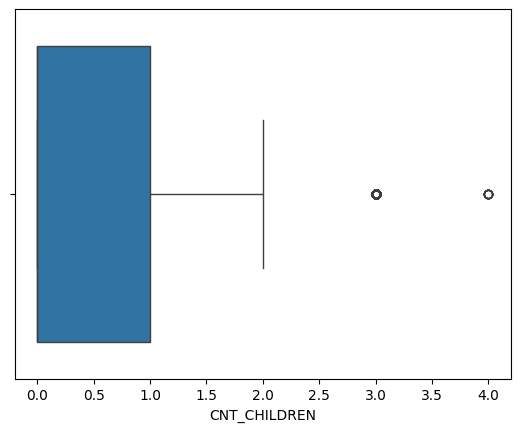

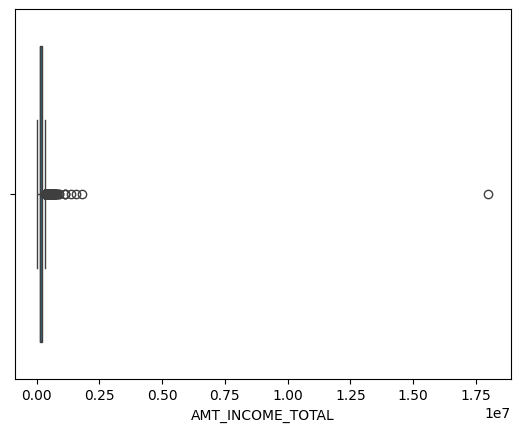

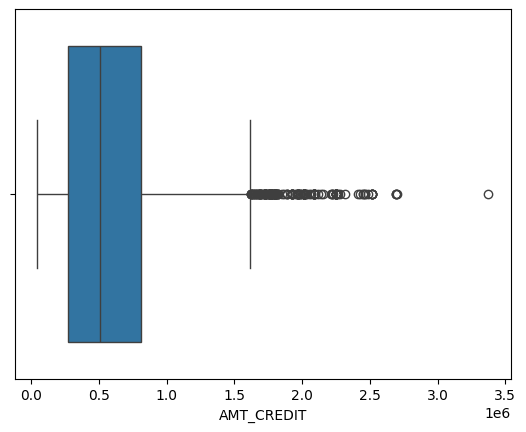

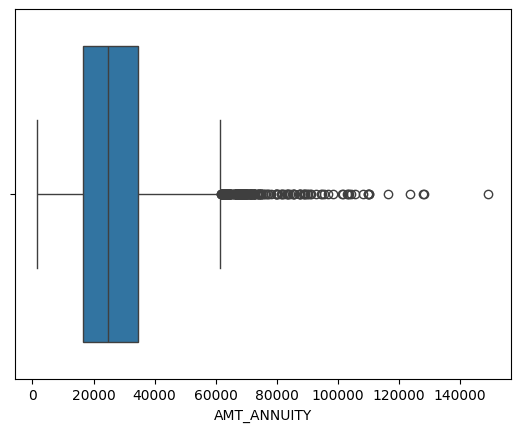

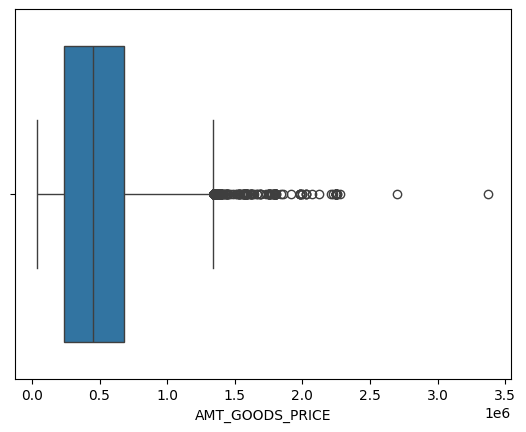

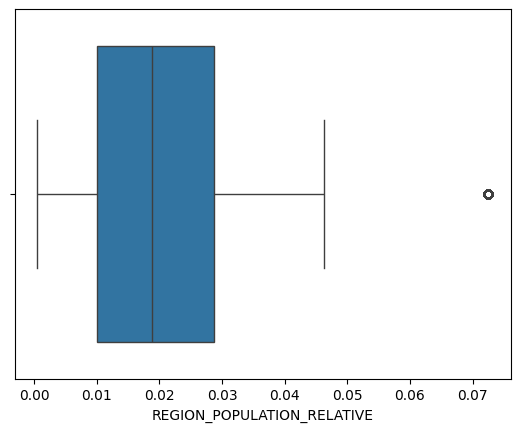

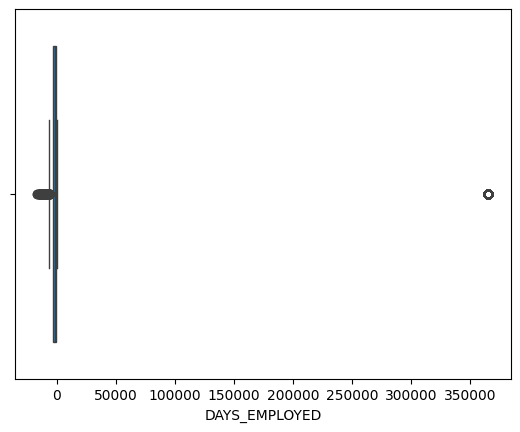

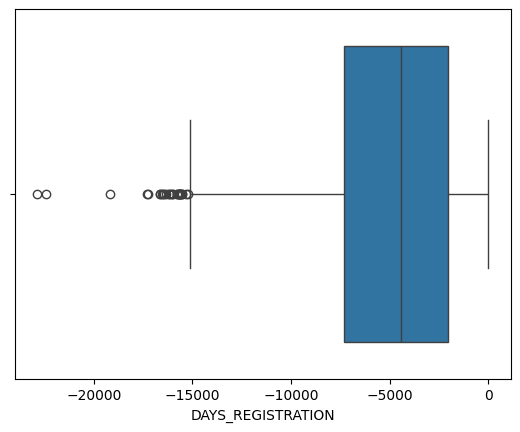

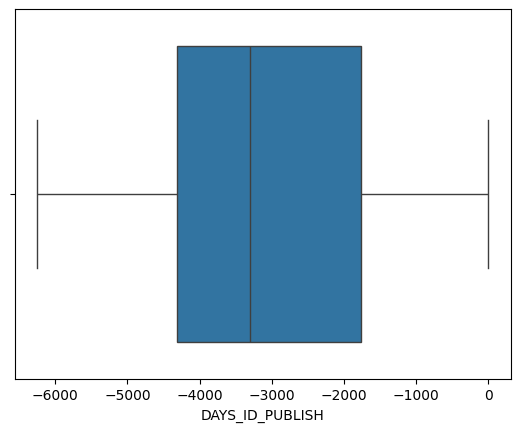

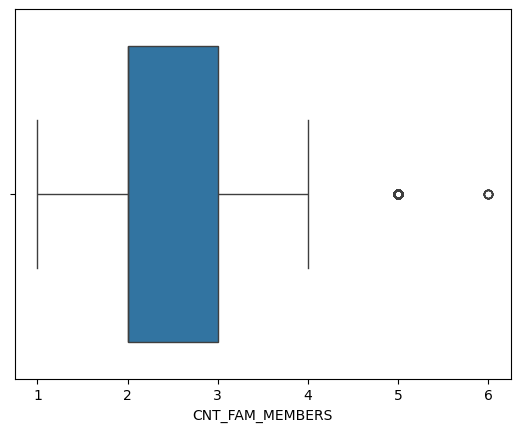

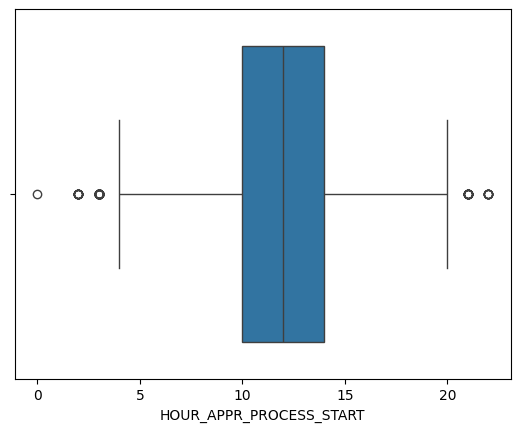

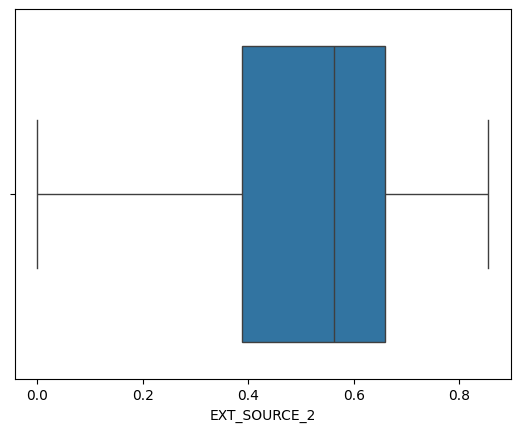

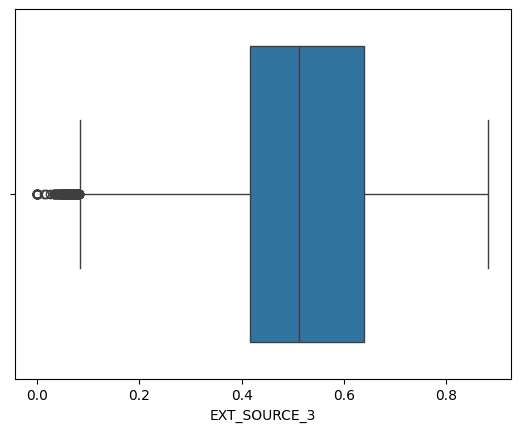

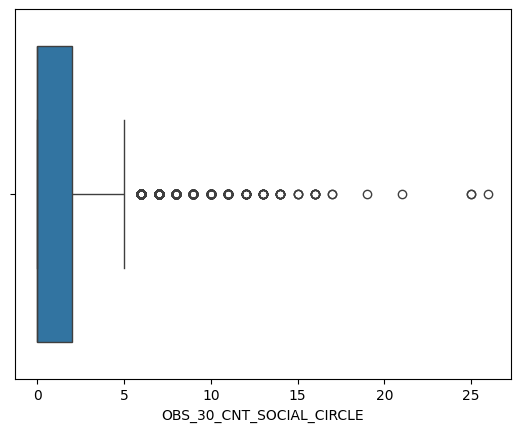

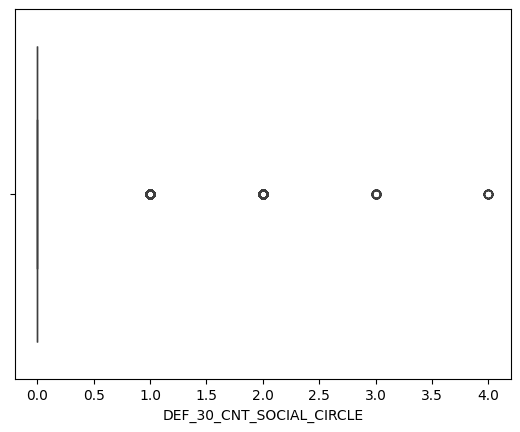

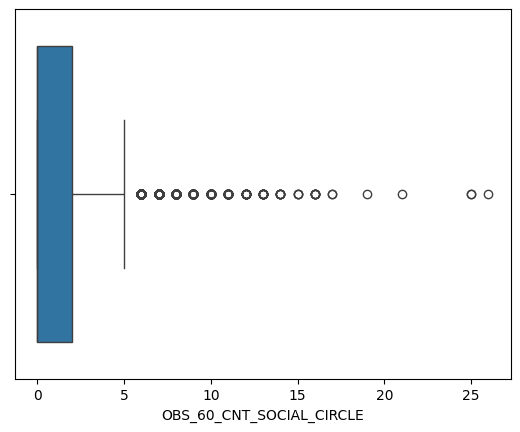

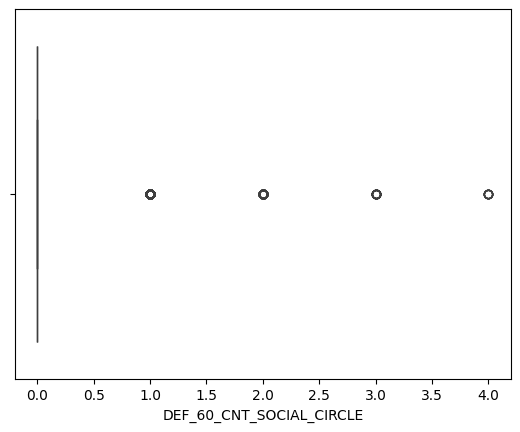

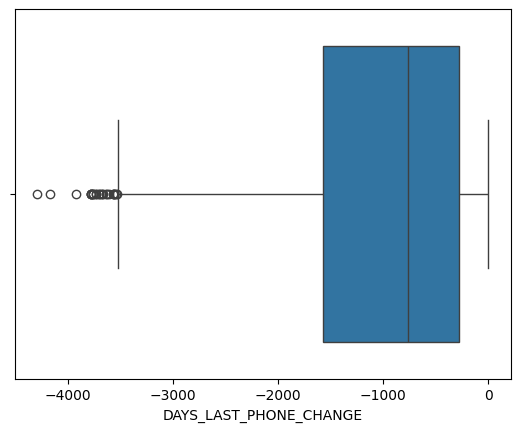

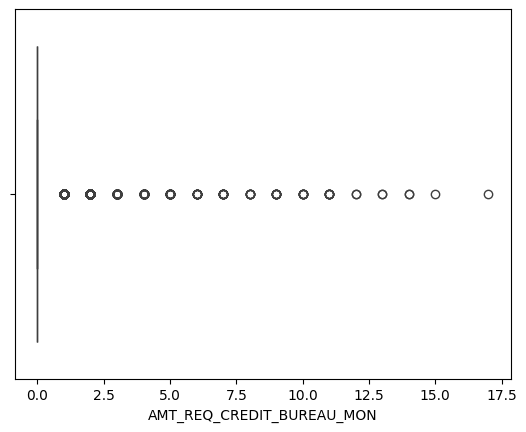

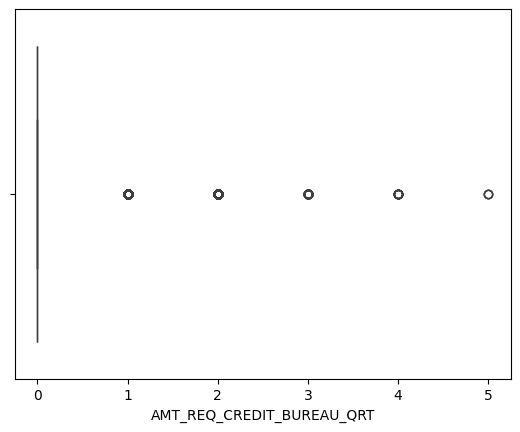

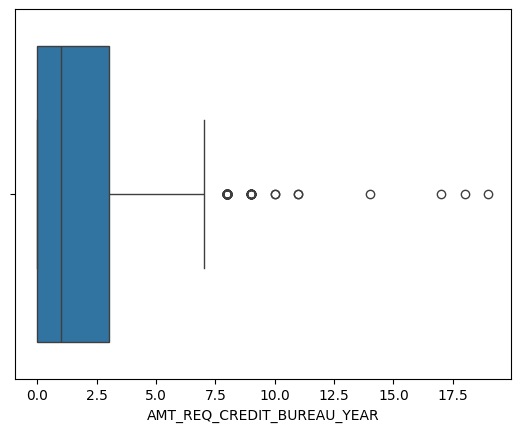

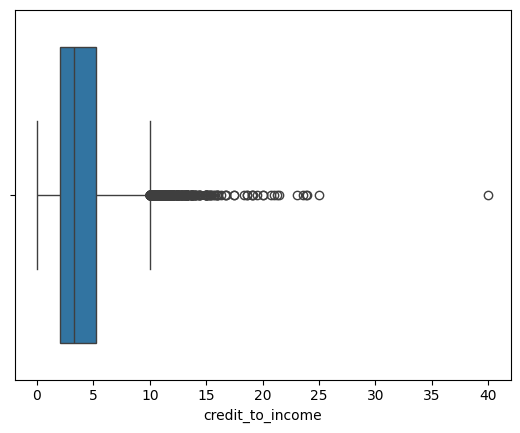

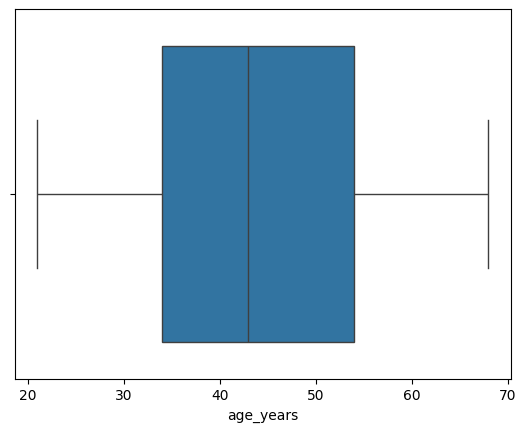

In [41]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object  and data_knn[i].nunique()>2:
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [42]:
q1=data_knn.quantile(0.25, numeric_only=True)
q3=data_knn.quantile(0.75, numeric_only=True)
IQR=q3-q1

Lower = q1-1.5*IQR
Upper = q3+1.5*IQR

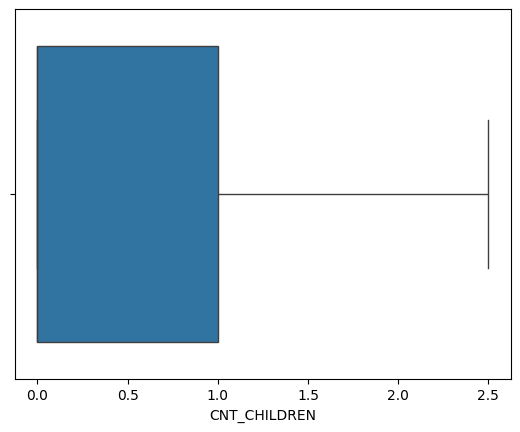

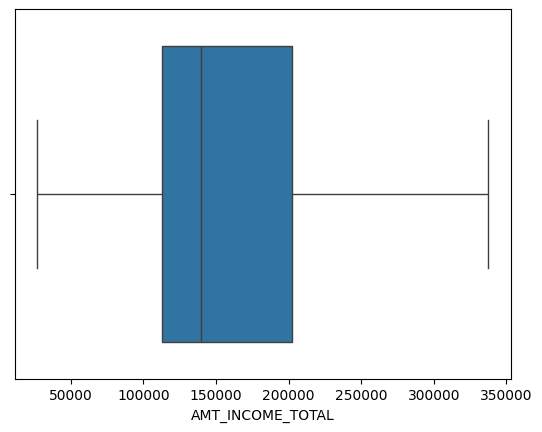

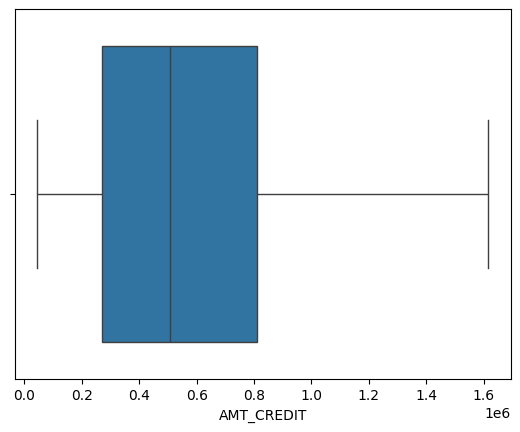

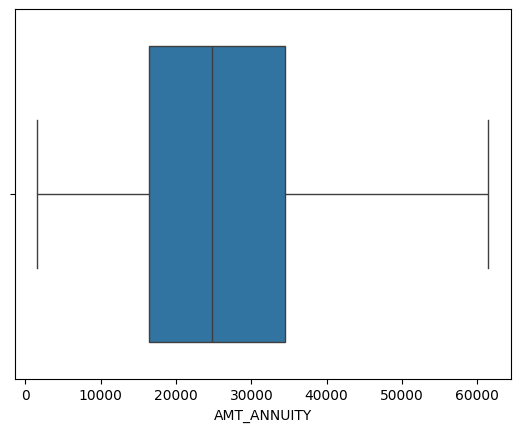

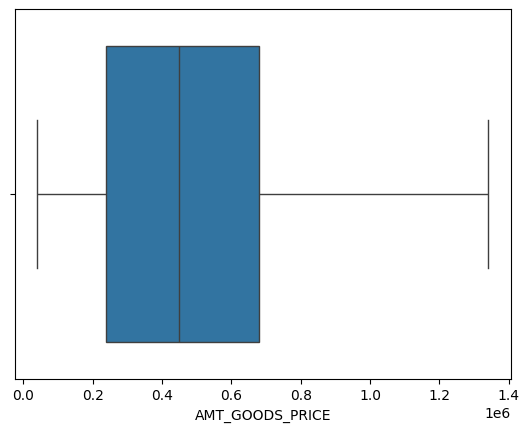

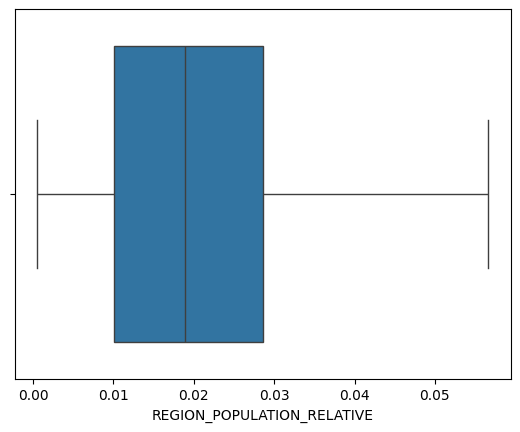

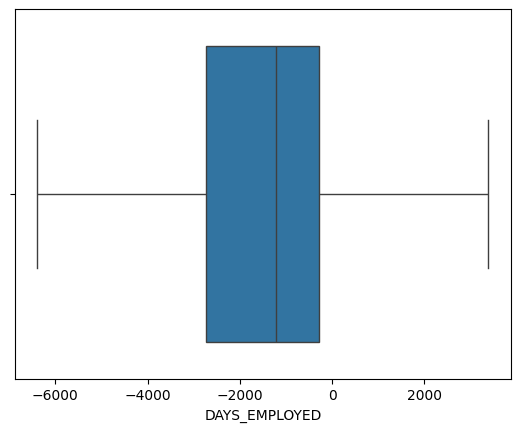

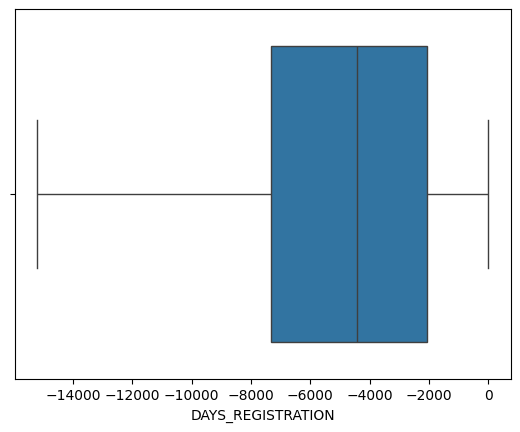

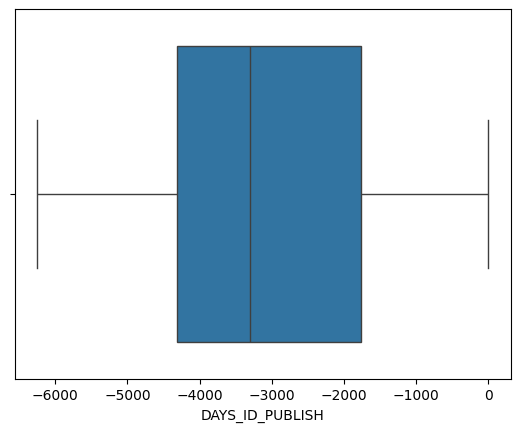

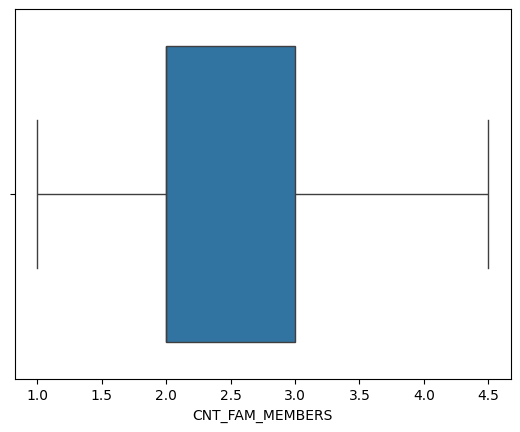

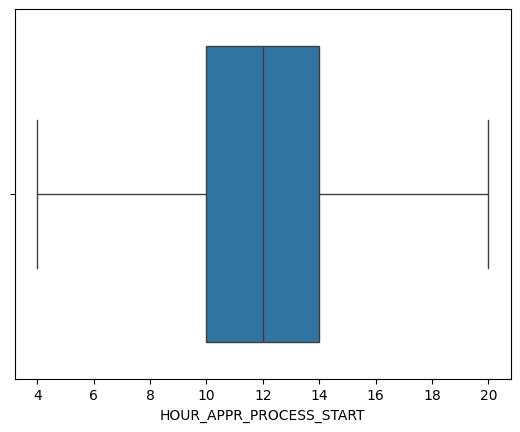

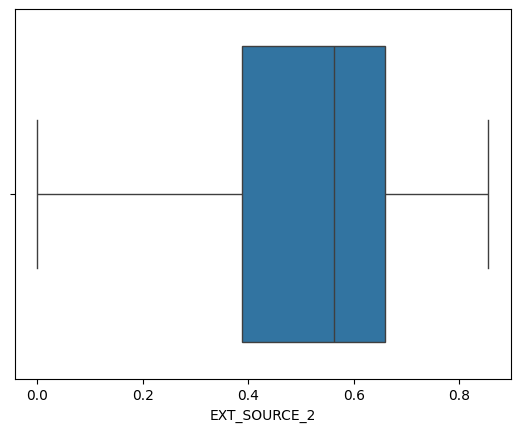

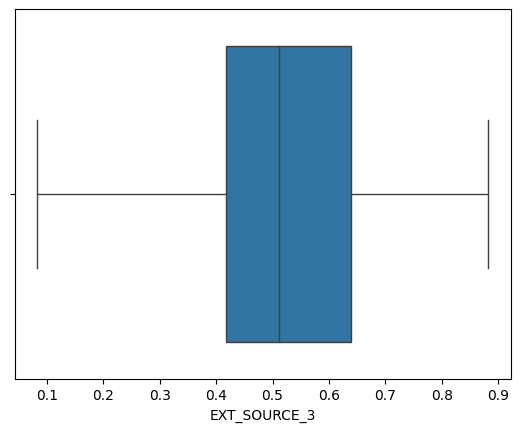

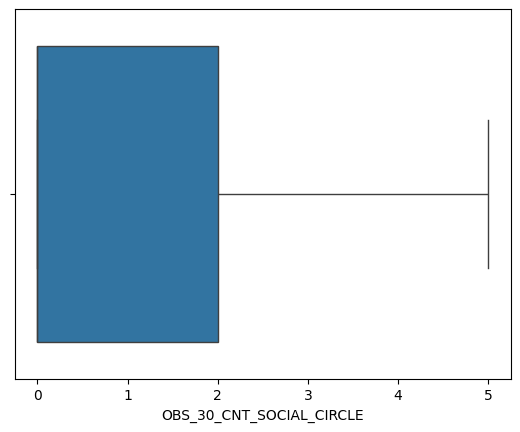

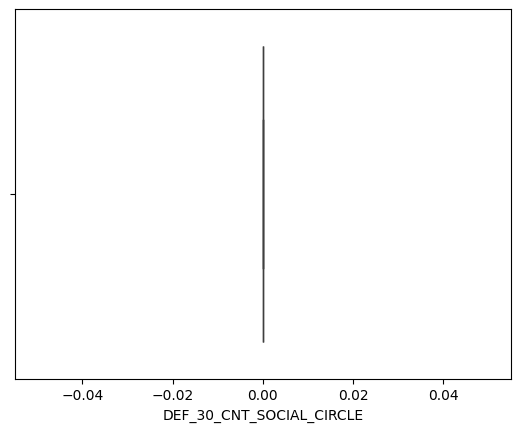

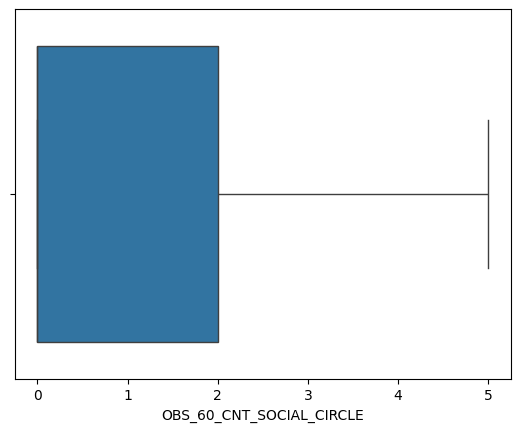

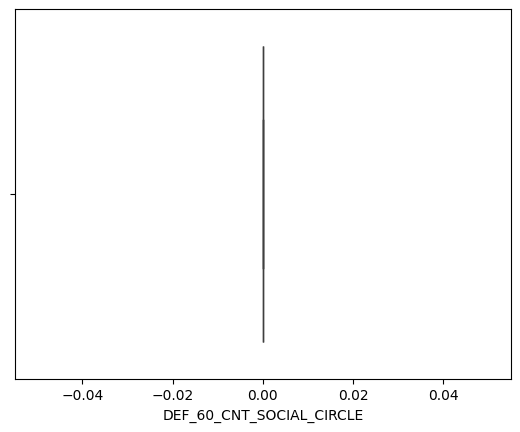

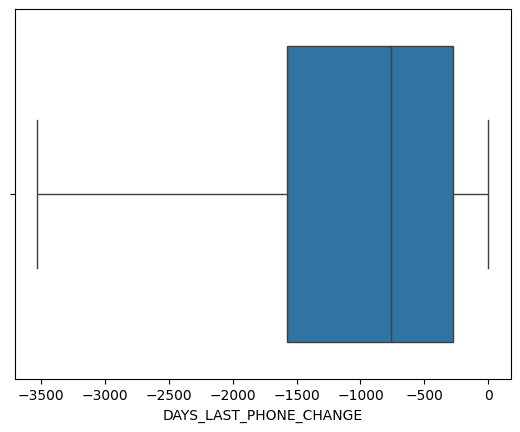

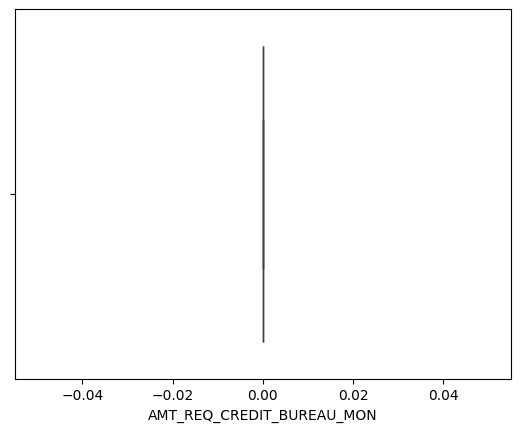

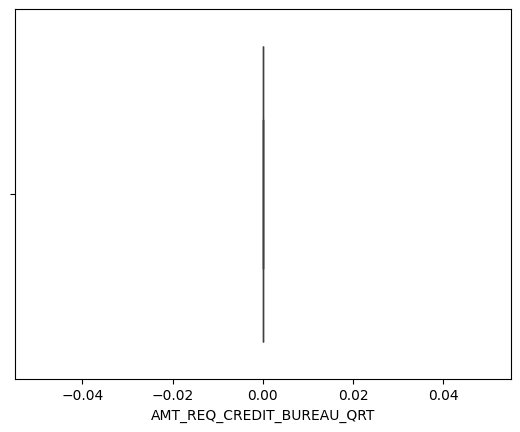

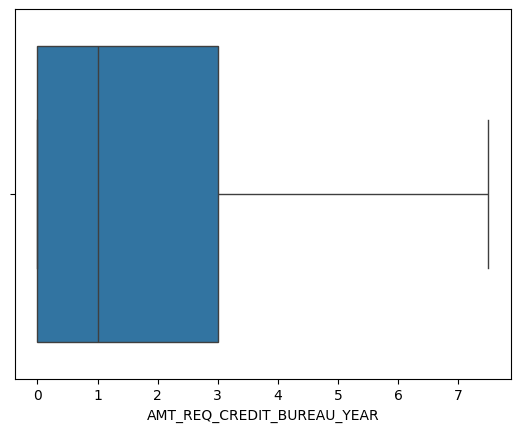

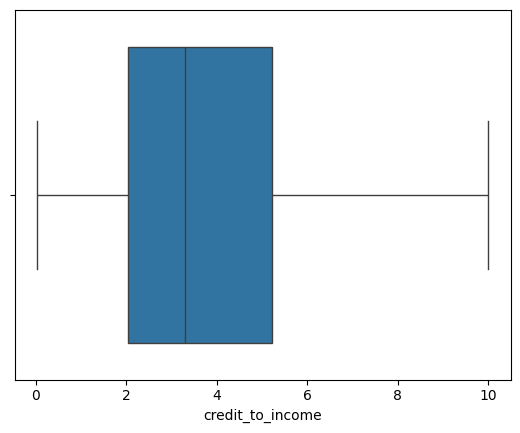

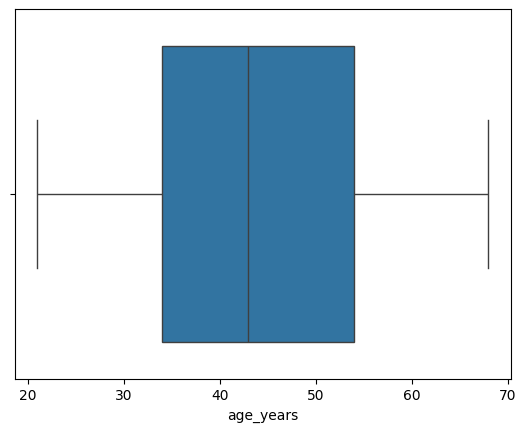

In [43]:
for i in data_knn.columns:
    if data_knn[i].dtypes!=object  and data[i].nunique()>2:
        data_knn[i] = np.where(data_knn[i] > Upper[i],Upper[i],data_knn[i])
        data_knn[i] = np.where(data_knn[i] < Lower[i],Lower[i],data_knn[i])
        sns.boxplot(data=data_knn,x=data_knn[i])
        plt.show()

In [44]:
def target_correlation(data, target, threshold=0.05):
    corr_matrix = data.corr(method='spearman', numeric_only=True)
    
    target_correlations = corr_matrix[target].abs() > threshold
    
    variables_explaining_target = target_correlations[target_correlations].index.tolist()

    variables_explaining_target.remove(target)
    
    result_explaining_target = pd.DataFrame(
    {'Variable': variables_explaining_target,
    'Correlation with Target': corr_matrix.loc[variables_explaining_target, target]})
    
    result_explaining_target.reset_index(drop=True, inplace=True)
    
    return result_explaining_target

target_result = target_correlation(data_knn, 'TARGET')

target_result

,Variable,Correlation with Target
0,REGION_RATING_CLIENT,0.057078
1,REGION_RATING_CLIENT_W_CITY,0.059384
2,REG_CITY_NOT_WORK_CITY,0.056009
3,EXT_SOURCE_2,-0.139742
4,EXT_SOURCE_3,-0.143811
5,DAYS_LAST_PHONE_CHANGE,0.052913
6,age_years,-0.056594


In [45]:
def intercorrelation(data, target, threshold=0.7):
    corr_matrix = data.drop(columns=[target]).corr(method='spearman', numeric_only=True)
    
    highly_correlated_variables = (np.abs(corr_matrix) > threshold) & (corr_matrix != 1.0)
    
    independent_variable_pairs = np.where(highly_correlated_variables)
    
    result_intercorrelated_independent = pd.DataFrame({
        'Variable 1': corr_matrix.index[independent_variable_pairs[0]],
        'Variable 2': corr_matrix.columns[independent_variable_pairs[1]]
    })
    return result_intercorrelated_independent

intercorrelated_result = intercorrelation(data_knn, 'TARGET')

intercorrelated_result

,Variable 1,Variable 2
0,CNT_CHILDREN,CNT_FAM_MEMBERS
1,AMT_CREDIT,AMT_ANNUITY
2,AMT_CREDIT,AMT_GOODS_PRICE
3,AMT_CREDIT,credit_to_income
4,AMT_ANNUITY,AMT_CREDIT
5,AMT_ANNUITY,AMT_GOODS_PRICE
6,AMT_GOODS_PRICE,AMT_CREDIT
7,AMT_GOODS_PRICE,AMT_ANNUITY
8,AMT_GOODS_PRICE,credit_to_income
9,CNT_FAM_MEMBERS,CNT_CHILDREN


In [46]:
target_result.Variable.tolist()

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'age_years']

In [48]:
def calculate_vif(data, variables):
    vif_data = data[variables]
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    vif_result = pd.DataFrame({'VIF': vif_values, 'Features': variables})
    return vif_result


vif_result = calculate_vif(data_knn, [
'REGION_RATING_CLIENT',
# 'REGION_RATING_CLIENT_W_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 #'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
# 'age_years'
 
])

vif_result

,VIF,Features
0,5.006506,REGION_RATING_CLIENT
1,1.318301,REG_CITY_NOT_WORK_CITY
2,5.175418,EXT_SOURCE_2
3,2.448118,DAYS_LAST_PHONE_CHANGE


In [49]:
cols_to_drop = [
    'REGION_RATING_CLIENT_W_CITY',
    'EXT_SOURCE_3',
    'age_years'
]

data_knn.drop(columns=cols_to_drop, inplace=True)
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,organization_group,occupation_group,credit_to_income,is_large_family,is_single_parent,age_years
871,1.0,Cash loans,F,N,N,0.0,90000.0,450000.0,21888.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-4815.0,-6556.0,-4295.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,TUESDAY,13.0,0.0,0.0,0.0,0.0,0.326084,0.511970,0.0,0.0,0.0,0.0,-1101.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Manual Labor,5.000000,0,0,33
30216,0.0,Cash loans,M,Y,Y,0.0,157500.0,277969.5,16087.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020246,-2468.0,-2563.0,-3968.0,1.0,1.0,1.0,0.0,2.0,3.0,3.0,TUESDAY,8.0,0.0,0.0,0.0,0.0,0.506491,0.191822,0.0,0.0,0.0,0.0,-2295.0,0.0,0.0,1.0,2.0,1.0,1.0,Industry / Manufacturing,Manual Labor,1.764886,0,0,31
71525,0.0,Cash loans,F,N,Y,0.0,180000.0,1205451.0,39969.0,1080000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.015221,-621.0,-8237.0,-1166.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,WEDNESDAY,11.0,0.0,0.0,0.0,0.0,0.717858,0.358951,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Finance / Accounting,6.696950,0,0,38
34743,1.0,Cash loans,M,N,Y,0.0,225000.0,528633.0,39654.0,472500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-241.0,-7233.0,-2184.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,FRIDAY,14.0,1.0,1.0,0.0,0.0,0.378102,0.504681,0.0,0.0,0.0,0.0,-317.0,1.0,0.0,0.0,0.0,0.0,9.0,Government / Public Sector,Manual Labor,2.349480,0,0,51
126024,0.0,Cash loans,F,N,N,0.0,180000.0,450000.0,22977.0,450000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.008019,-211.0,-7942.0,-1813.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,SATURDAY,17.0,0.0,0.0,0.0,0.0,0.471828,0.511970,0.0,0.0,0.0,0.0,-534.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Professional / Skilled,2.500000,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119433,0.0,Cash loans,F,N,N,0.0,90000.0,127350.0,12726.0,112500.0,Unaccompanied,State servant,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-758.0,-11203.0,-644.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,SUNDAY,15.0,0.0,0.0,0.0,0.0,0.449437,0.511970,1.0,0.0,1.0,0.0,-473.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Manual Labor,1.415000,0,0,46
88911,0.0,Cash loans,F,N,Y,0.0,135000.0,509922.0,36396.0,472500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,365243.0,-14120.0,-4282.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,THURSDAY,16.0,0.0,0.0,0.0,0.0,0.742715,0.819318,2.0,1.0,2.0,1.0,-3019.0,1.0,0.0,0.0,0.0,0.0,4.0,Other,Other,3.777200,0,0,61
106379,0.0,Cash loans,F,N,Y,0.0,112500.0,277969.5,10606.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.031329,-499.0,-4865.0,-484.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,1.0,1.0,0.0,0.424992,0.424130,4.0,0.0,4.0,0.0,-1785.0,1.0,0.0,0.0,0.0,1.0,0.0,Trade & Services,Sales & Service,2.470840,0,0,30
26

In [50]:

data_knn = pd.get_dummies(data_knn, drop_first=True, dtype=int)

data_knn

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credit_to_income,is_large_family,is_single_parent,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,organization_group_Culture & Religion,organization_group_Education,organization_group_Finance & Insurance,organization_group_Government / Public Sector,organization_group_Health / Medicine,organization_group_Housing / Misc,organization_group_Industry / Manufacturing,organization_group_Other,organization_group_Telecom / Mobile,organization_group_Trade & Services,occupation_group_Finance / Accounting,occupation_group_Management,occupation_group_Manual Labor,occupation_group_Other,occupation_group_Professional / Skilled,occupation_group_Sales & Service
871,1.0,0.0,90000.0,450000.0,21888.0,450000.0,0.035792,-4815.000,-6556.0,-4295.0,1.0,1.0,0.0,0.0,1.0,2.0,13.0,0.0,0.0,0.0,0.0,0.326084,0.0,0.0,0.0,0.0,-1101.0,1.0,0.0,0.0,0.0,0.0,0.0,5.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
30216,0.0,0.0,157500.0,277969.5,16087.5,229500.0,0.020246,-2468.000,-2563.0,-3968.0,1.0,1.0,1.0,0.0,2.0,3.0,8.0,0.0,0.0,0.0,0.0,0.506491,0.0,0.0,0.0,0.0,-2295.0,0.0,0.0,1.0,0.0,0.0,1.0,1.764886,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
71525,0.0,0.0,180000.0,1205451.0,39969.0,1080000.0,0.015221,-621.000,-8237.0,-1166.0,1.0,1.0,1.0,0.0,1.0,2.0,11.0,0.0,0.0,0.0,0.0,0.717858,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.696950,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
34743,1.0,0.0,225000.0,528633.0,39654.0,472500.0,0.018850,-241.000,-7233.0,-2184.0,1.0,0.0,0.0,0.0,1.0,2.0,14.0,1.0,1.0,0.0,0.0,0.378102,0.0,0.0,0.0,0.0,-317.0,1.0,0.0,0.0,0.0,0.0,7.5,2.349480,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
126024,0.0,0.0,180000.0,450000.0,22977.0,450000.0,0.008019,-211.000,-7942.0,-1813.0,1.0,0.0,0.0,0.0,1.0,2.0,17.0,0.0,0.0,0.0,0.0,0.471828,0.0,0.0,0.0,0.0,-534.0,1.0,0.0,0.0,0.0,0.0,0.0,2.500000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [51]:
#RF and XGB and CT and lGB

In [52]:
le = LabelEncoder()

for i in data_rf_xgb_lgb_cb.columns:
    data_rf_xgb_lgb_cb[i] = le.fit_transform(data_rf_xgb_lgb_cb[i])
data_rf_xgb_lgb_cb

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,organization_group,occupation_group,credit_to_income,is_large_family,is_single_parent,age_years
871,1,0,0,0,0,0,74,634,1655,98,5,6,4,3,1,77,937,2441,973,1,1,0,0,0,1,1,5,12,0,0,0,0,1725,404,0,0,0,0,1643,1,0,0,0,0,0,7,3,3446,0,0,12
30216,0,0,1,1,1,0,139,343,965,45,5,6,4,1,1,66,2157,4982,1297,1,1,1,0,1,2,2,5,7,0,0,0,0,3743,197,0,0,0,0,566,0,0,1,2,1,1,7,3,933,0,0,10
71525,0,0,0,0,1,0,160,1546,3364,242,5,6,1,3,1,57,3734,1602,3546,1,1,1,0,0,1,1,6,10,0,0,0,0,8585,316,0,0,0,0,2723,1,0,0,0,0,0,7,1,4150,0,0,17
34743,1,0,1,0,1,0,187,775,3344,103,5,6,4,2,1,63,4093,2087,2754,1,0,0,0,0,1,1,0,13,1,1,0,0,2183,399,0,0,0,0,2416,1,0,0,0,0,9,4,3,1459,0,0,30
126024,0,0,0,0,0,0,160,634,1783,98,5,6,2,3,1,33,4123,1748,3049,1,0,0,0,0,1,1,2,16,0,0,0,0,3228,404,0,0,0,0,2200,1,0,0,0,0,0,0,5,1597,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119433,0,0,0,0,0,0,74,94,586,16,5,3,4,0,1,79,3610,480,3966,1,1,1,0,1,0,0,3,14,0,0,0,0,2967,404,1,0,1,0,2261,1,0,0,0,0,0,0,3,601,0,0,25
88911,0,0,0,0,1,0,119,739,3122,103,5,2,4,1,1,63,4261,71,986,0,0,0,0,1,1,1,4,15,0,0,0,0,9039,606,2,1,2,1,141,1,0,0,0,0,4,8,4,2675,0,0,40
106379,0,0,0,0,1,0,96,343,383,45,5,6,4,3,1,75,3849,3436,4080,1,0,0,0,0,1,1,6,9,0,1,1,0,2690,354,4,0,4,0,998,1,0,0,0,1,0,10,6,1569,0,0,9
26336,0,0,0,0,1,1,96,259,893,45,5,0,4,2,1,60,3373,1957,806,1,0,1,0,1,2,2,1,12,0,0,0,0,3465,404,6,0,6,0,76,1,0,0,0,0,0,0,3,1182,0,1,15


In [53]:
data_cbc

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,organization_group,occupation_group,credit_to_income,is_large_family,is_single_parent,age_years
871,1.0,Cash loans,F,N,N,0.0,90000.0,450000.0,21888.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-4815.0,-6556.0,-4295.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,TUESDAY,13.0,0.0,0.0,0.0,0.0,0.326084,0.511970,0.0,0.0,0.0,0.0,-1101.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Manual Labor,5.000000,0,0,33
30216,0.0,Cash loans,M,Y,Y,0.0,157500.0,277969.5,16087.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020246,-2468.0,-2563.0,-3968.0,1.0,1.0,1.0,0.0,2.0,3.0,3.0,TUESDAY,8.0,0.0,0.0,0.0,0.0,0.506491,0.191822,0.0,0.0,0.0,0.0,-2295.0,0.0,0.0,1.0,2.0,1.0,1.0,Industry / Manufacturing,Manual Labor,1.764886,0,0,31
71525,0.0,Cash loans,F,N,Y,0.0,180000.0,1205451.0,39969.0,1080000.0,Unaccompanied,Working,Higher education,Single / not married,House / apartment,0.015221,-621.0,-8237.0,-1166.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,WEDNESDAY,11.0,0.0,0.0,0.0,0.0,0.717858,0.358951,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Industry / Manufacturing,Finance / Accounting,6.696950,0,0,38
34743,1.0,Cash loans,M,N,Y,0.0,225000.0,528633.0,39654.0,472500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-241.0,-7233.0,-2184.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,FRIDAY,14.0,1.0,1.0,0.0,0.0,0.378102,0.504681,0.0,0.0,0.0,0.0,-317.0,1.0,0.0,0.0,0.0,0.0,9.0,Government / Public Sector,Manual Labor,2.349480,0,0,51
126024,0.0,Cash loans,F,N,N,0.0,180000.0,450000.0,22977.0,450000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.008019,-211.0,-7942.0,-1813.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,SATURDAY,17.0,0.0,0.0,0.0,0.0,0.471828,0.511970,0.0,0.0,0.0,0.0,-534.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Professional / Skilled,2.500000,0,0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119433,0.0,Cash loans,F,N,N,0.0,90000.0,127350.0,12726.0,112500.0,Unaccompanied,State servant,Secondary / secondary special,Civil marriage,House / apartment,0.072508,-758.0,-11203.0,-644.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,SUNDAY,15.0,0.0,0.0,0.0,0.0,0.449437,0.511970,1.0,0.0,1.0,0.0,-473.0,1.0,0.0,0.0,0.0,0.0,0.0,Business / Corporate,Manual Labor,1.415000,0,0,46
88911,0.0,Cash loans,F,N,Y,0.0,135000.0,509922.0,36396.0,472500.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.018850,365243.0,-14120.0,-4282.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,THURSDAY,16.0,0.0,0.0,0.0,0.0,0.742715,0.819318,2.0,1.0,2.0,1.0,-3019.0,1.0,0.0,0.0,0.0,0.0,4.0,Other,Other,3.777200,0,0,61
106379,0.0,Cash loans,F,N,Y,0.0,112500.0,277969.5,10606.5,229500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.031329,-499.0,-4865.0,-484.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,WEDNESDAY,10.0,0.0,1.0,1.0,0.0,0.424992,0.424130,4.0,0.0,4.0,0.0,-1785.0,1.0,0.0,0.0,0.0,1.0,0.0,Trade & Services,Sales & Service,2.470840,0,0,30
26

In [54]:
output = data['TARGET']

In [55]:
inputs_lr = data_lr[LR_vars]
inputs_knn = data_knn.drop('TARGET', axis=1)
inputs_rf_xgb_lgb_cb = data_rf_xgb_lgb_cb.drop('TARGET', axis=1)
inputs_cbc = data_cbc.drop('TARGET', axis=1)

In [56]:
scaler = StandardScaler()
scaler.fit(inputs_knn)
inputs_scaled = scaler.transform(inputs_knn)

data_scaled_knn = pd.DataFrame(inputs_scaled, columns=inputs_knn.columns)

data_scaled_knn

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,credit_to_income,is_large_family,is_single_parent,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,organization_group_Culture & Religion,organization_group_Education,organization_group_Finance & Insurance,organization_group_Government / Public Sector,organization_group_Health / Medicine,organization_group_Housing / Misc,organization_group_Industry / Manufacturing,organization_group_Other,organization_group_Telecom / Mobile,organization_group_Trade & Services,occupation_group_Finance / Accounting,occupation_group_Management,occupation_group_Manual Labor,occupation_group_Other,occupation_group_Professional / Skilled,occupation_group_Sales & Service
0,-0.596986,-0.965192,-0.362764,-0.361676,-0.220100,1.241286,-1.339660,-0.474905,-0.848931,0.475280,1.966472,-0.613014,-0.237018,-1.294400,-0.136270,0.325091,-0.233797,-0.309501,-0.583189,-0.494098,-0.968182,-0.723520,0.0,-0.720275,0.0,-0.158081,0.646600,-0.312697,-0.302661,0.0,0.0,-0.909534,0.461833,-0.121662,-0.213915,-0.323998,-0.713615,-0.716565,-1.464566,-0.383572,-0.031198,-0.05225,-0.088544,0.425421,-0.009861,-0.475126,-0.276420,-0.009861,-0.009861,0.962957,-0.561778,-0.189913,-0.117903,0.637387,-1.331433,-0.268595,2.451576,-0.242461,0.364484,-0.191556,-0.092368,-0.135718,-0.232638,-0.439835,-0.356390,-0.244924,-0.437471,2.159397,-0.447840,-0.041873,-0.253072,-0.101075,-0.279869,-0.201693,-0.097071,3.601781,-0.614065,-0.048365,-0.265671,-0.174531,-0.273556,1.533274,-0.682031,-0.42924,-0.378048
1,-0.596986,-0.036059,-0.817371,-0.802795,-0.877611,-0.012525,-0.476959,0.685369,-0.631946,0.475280,1.966472,1.631285,-0.237018,-0.165724,1.791383,-1.230336,-0.233797,-0.309501,-0.583189,-0.494098,-0.020164,-0.723520,0.0,-0.720275,0.0,-1.596522,-1.546551,-0.312697,3.304023,0.0,0.0,-0.356473,-0.893957,-0.121662,-0.213915,-0.323998,1.401317,1.395546,0.682796,-0.383572,-0.031198,-0.05225,-0.088544,0.425421,-0.009861,-0.475126,-0.276420,-0.009861,-0.009861,0.962957,-0.561778,-0.189913,-0.117903,0.637387,0.751070,-0.268595,-0.407901,-0.242461,0.364484,-0.191556,-0.092368,-0.135718,-0.232638,-0.439835,-0.356390,-0.244924,-0.437471,2.159397,-0.447840,-0.041873,-0.253072,-0.101075,-0.279869,-0.201693,-0.097071,3.601781,-0.614065,-0.048365,-0.265671,-0.174531,-0.273556,1.533274,-0.682031,-0.42924,-0.378048
2,-0.596986,0.273652,1.633585,1.013358,1.658503,-0.417800,0.201955,-0.963365,1.227358,0.475280,1.9664

In [57]:
X_train_lr, X_test_lr, y_train, y_test = train_test_split(inputs_lr, output, test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train, y_test = train_test_split(data_scaled_knn, output, test_size=0.2, random_state=42)
X_train_rf_xgb_lgb_cb, X_test_rf_xgb_lgb_cb, y_train, y_test = train_test_split(inputs_rf_xgb_lgb_cb, output, test_size=0.2, random_state=42)
X_train_cbc, X_test_cbc, y_train, y_test = train_test_split(inputs_cbc, output, test_size=0.2, random_state=42)

In [58]:
def train_and_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    try:
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_prob_train = model.predict_proba(X_train)[:, 1]

        roc_prob_train = roc_auc_score(y_train, y_prob_train)
        gini_prob_train = roc_prob_train * 2 - 1
        confusion_matrix_result_train = confusion_matrix(y_train, y_pred_train)
        classification_report_result_train = classification_report(y_train, y_pred_train)

        print(f'Model Performance for {model_name}')
        print('Train Gini prob is', gini_prob_train * 100)
        print(classification_report_result_train)
        print(confusion_matrix_result_train)

        y_pred_test = model.predict(X_test)
        y_prob_test = model.predict_proba(X_test)[:, 1]

        roc_prob_test = roc_auc_score(y_test, y_prob_test)
        gini_prob_test = roc_prob_test * 2 - 1
        confusion_matrix_result_test = confusion_matrix(y_test, y_pred_test)
        classification_report_result_test = classification_report(y_test, y_pred_test)

        print(f'Model Performance for {model_name}')
        print('Test Gini prob is', gini_prob_test * 100)
        print(classification_report_result_test)
        print(confusion_matrix_result_test)

        return [gini_prob_train, gini_prob_test]

    except Exception as e:
        print(f"An error occurred while evaluating the model {model_name}: {e}")
        return None


In [59]:
for i in data_cbc.columns:
    if data_cbc[i].dtypes==object:
        print(i)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
WEEKDAY_APPR_PROCESS_START
organization_group
occupation_group


In [60]:
models = []

lr_model = LogisticRegression()
knn_model_def = KNeighborsClassifier()
rf_model_def = RandomForestClassifier(random_state=42)
xgb_model_def = XGBClassifier(random_state=42)
lgb_model_def = LGBMClassifier(random_state=42)
catboost_model_def = CatBoostClassifier(random_state=42)
catboost_model_custom = CatBoostClassifier(cat_features=[
'NAME_CONTRACT_TYPE',
'CODE_GENDER',
'FLAG_OWN_CAR',
'FLAG_OWN_REALTY',
'NAME_TYPE_SUITE',
'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE',
'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE',
'WEEKDAY_APPR_PROCESS_START',
'organization_group',
'occupation_group'

], random_state=42)

models.extend([
    ('LogReg', lr_model),
    ('KNN', knn_model_def),
    ('RF', rf_model_def),
    ('XGBoost', xgb_model_def),
    ('LGBoost', lgb_model_def),
    ('CatBoost', catboost_model_def),
    ('CatBoost_Custom', catboost_model_custom)
])

In [61]:
gini_df = pd.DataFrame(columns=['Model', 'Train Gini', 'Test Gini'])

for model_name, model in models:
    if model_name == 'LogReg':
        gini_prob = train_and_evaluate_model(model_name, model, X_train_lr, y_train, X_test_lr, y_test)
    elif model_name == 'KNN':
        gini_prob = train_and_evaluate_model(model_name, model, X_train_knn, y_train, X_test_knn, y_test)
    elif model_name == 'CatBoost_Custom':
        gini_prob = train_and_evaluate_model(model_name, model, X_train_cbc, y_train, X_test_cbc, y_test)
    else:
        gini_prob = train_and_evaluate_model(model_name, model, X_train_rf_xgb_lgb_cb, y_train, X_test_rf_xgb_lgb_cb, y_test)

    if gini_prob is not None:
        gini_df = pd.concat([gini_df, pd.DataFrame({'Model': [model_name], 'Train Gini': [gini_prob[0]], 'Test Gini': [gini_prob[1]]})], ignore_index=True)

gini_df_sorted = gini_df.sort_values(by='Test Gini', ascending=False)

gini_df_sorted

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\sit

Model Performance for LogReg
Train Gini prob is 41.17537938721269
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.00      0.00      0.00       680

    accuracy                           0.92      8227
   macro avg       0.46      0.50      0.48      8227
weighted avg       0.84      0.92      0.88      8227

[[7547    0]
 [ 680    0]]
Model Performance for LogReg
Test Gini prob is 38.918415729323705
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]
Model Performance for KNN
Train Gini prob is 77.31550908424853
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.9

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Performance for XGBoost
Train Gini prob is 100.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7547
         1.0       1.00      0.99      0.99       680

    accuracy                           1.00      8227
   macro avg       1.00      0.99      1.00      8227
weighted avg       1.00      1.00      1.00      8227

[[7547    0]
 [   7  673]]
Model Performance for XGBoost
Test Gini prob is 34.532874647288466
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      1893
         1.0       0.32      0.05      0.09       164

    accuracy                           0.92      2057
   macro avg       0.62      0.52      0.52      2057
weighted avg       0.88      0.92      0.89      2057

[[1874   19]
 [ 155    9]]
[LightGBM] [Info] Number of positive: 680, number of negative: 7547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003403 seconds

,Model,Train Gini,Test Gini
6,CatBoost_Custom,0.923041,0.392660
0,LogReg,0.411754,0.389184
5,CatBoost,0.967837,0.357762
4,LGBoost,0.997325,0.353736
3,XGBoost,1.000000,0.345329
2,RF,1.000000,0.280588
1,KNN,0.773155,0.091589


In [62]:
gini_df_sorted

,Model,Train Gini,Test Gini
6,CatBoost_Custom,0.923041,0.392660
0,LogReg,0.411754,0.389184
5,CatBoost,0.967837,0.357762
4,LGBoost,0.997325,0.353736
3,XGBoost,1.000000,0.345329
2,RF,1.000000,0.280588
1,KNN,0.773155,0.091589


In [63]:
#LR

In [64]:
inputs_lr.columns

Index(['CODE_GENDER_woe', 'DAYS_EMPLOYED_woe', 'REG_CITY_NOT_WORK_CITY_woe',
       'EXT_SOURCE_2_woe', 'EXT_SOURCE_3_woe', 'DAYS_LAST_PHONE_CHANGE_woe',
       'occupation_group_woe', 'age_years_woe'],
      dtype='object')

In [65]:

variables = []
train_gini_scores = []
test_gini_scores = []


for i in X_train_lr.columns:
    X_train_single_var = X_train_lr[[i]]
    X_test_single_var = X_test_lr[[i]]


    lr_model.fit(X_train_single_var, y_train)
    y_pred_train_single_var = lr_model.predict_proba(X_train_single_var)[:, 1]


    train_roc = roc_auc_score(y_train, y_pred_train_single_var)

    train_gini = 2 * train_roc - 1


    y_pred_test_single_var = lr_model.predict_proba(X_test_single_var)[:, 1]

    test_roc = roc_auc_score(y_test, y_pred_test_single_var)

    test_gini = 2 * test_roc - 1

    variables.append(i)
    train_gini_scores.append(train_gini)
    test_gini_scores.append(test_gini)

results_df = pd.DataFrame({
    'Variable': variables,
    'Train Gini': train_gini_scores,
    'Test Gini': test_gini_scores
})

results_df_sorted = results_df.sort_values(by='Test Gini', ascending=False)


pd.options.display.float_format = '{:.4f}'.format


results_df_sorted


,Variable,Train Gini,Test Gini
3,EXT_SOURCE_2_woe,0.2658,0.2663
4,EXT_SOURCE_3_woe,0.2841,0.2527
6,occupation_group_woe,0.1123,0.1560
5,DAYS_LAST_PHONE_CHANGE_woe,0.1144,0.0917
2,REG_CITY_NOT_WORK_CITY_woe,0.0887,0.0895
0,CODE_GENDER_woe,0.0933,0.0791
1,DAYS_EMPLOYED_woe,0.1364,0.0582
7,age_years_woe,0.1367,0.0193


In [66]:
filtered_df = results_df_sorted[
    (results_df_sorted['Test Gini'] > 0.1) &
    (abs(results_df_sorted['Train Gini'] - results_df_sorted['Test Gini']) <= 0.05)
]

filtered_df

,Variable,Train Gini,Test Gini
3,EXT_SOURCE_2_woe,0.2658,0.2663
4,EXT_SOURCE_3_woe,0.2841,0.2527
6,occupation_group_woe,0.1123,0.1560


In [67]:
# LR
selected_vars = filtered_df['Variable'].tolist()
X = inputs_lr[selected_vars]  
y = output                     

X_train_lr_uni, X_test_lr_uni, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_uni_model = LogisticRegression(max_iter=1000)
lr_uni_model.fit(X_train_lr_uni, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [68]:
# KNN

from sklearn.model_selection import cross_val_score
import optuna

def best_params_for_model(trial):
    param = {
    'n_neighbors': trial.suggest_int('n_neighbors', 1, 50), 
    'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  
    'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),  
    'leaf_size': trial.suggest_int('leaf_size', 10, 100),  
    'p': trial.suggest_int('p', 1, 2),  
    'metric': trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan']) 
}

    knn_clf = KNeighborsClassifier(**param)

    roc = cross_val_score(knn_clf, X_train_knn, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return roc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_knn_model = KNeighborsClassifier(**best_params)

[I 2025-11-06 20:12:14,811] A new study created in memory with name: no-name-894d9f35-4e8f-4caf-97d5-263e627e9b99
[I 2025-11-06 20:12:21,439] Trial 0 finished with value: 0.5689714017543872 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 22, 'p': 1, 'metric': 'manhattan'}. Best is trial 0 with value: 0.5689714017543872.
[I 2025-11-06 20:12:25,905] Trial 1 finished with value: 0.5748256736041355 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 35, 'p': 2, 'metric': 'minkowski'}. Best is trial 1 with value: 0.5748256736041355.
[I 2025-11-06 20:12:34,215] Trial 2 finished with value: 0.576279738140434 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 32, 'p': 1, 'metric': 'manhattan'}. Best is trial 2 with value: 0.576279738140434.
[I 2025-11-06 20:12:38,369] Trial 3 finished with value: 0.5518812072378093 and parameters: {'n_neighbors': 13, 'weights': 'un

Best trial:
  Value: 0.581
  Params:  {'n_neighbors': 43, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 70, 'p': 1, 'metric': 'manhattan'}


In [69]:
# RF

from sklearn.model_selection import cross_val_score
import optuna

def best_params_for_model(trial):
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),  
    'max_depth': trial.suggest_int('max_depth', 10, 50),  
    'min_samples_split': trial.suggest_int('min_samples_split', 10, 200),  
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),  
}

    rf_clf = RandomForestClassifier(**param)

    roc = cross_val_score(rf_clf, X_train_rf_xgb_lgb_cb, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return roc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_rf_model = RandomForestClassifier(**best_params)

[I 2025-11-06 20:15:03,161] A new study created in memory with name: no-name-ffe98cfe-44fa-4836-b454-024f7766bd1d
[I 2025-11-06 20:15:10,513] Trial 0 finished with value: 0.7049605864359357 and parameters: {'n_estimators': 349, 'max_features': 'log2', 'max_depth': 43, 'min_samples_split': 94, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7049605864359357.
[I 2025-11-06 20:15:18,026] Trial 1 finished with value: 0.7113475535567275 and parameters: {'n_estimators': 309, 'max_features': 'sqrt', 'max_depth': 33, 'min_samples_split': 96, 'min_samples_leaf': 33}. Best is trial 1 with value: 0.7113475535567275.
[I 2025-11-06 20:15:21,010] Trial 2 finished with value: 0.7102371403316241 and parameters: {'n_estimators': 128, 'max_features': 'sqrt', 'max_depth': 48, 'min_samples_split': 139, 'min_samples_leaf': 36}. Best is trial 1 with value: 0.7113475535567275.
[I 2025-11-06 20:15:31,669] Trial 3 finished with value: 0.7049995449972546 and parameters: {'n_estimators': 433, 'max_feature

Best trial:
  Value: 0.715
  Params:  {'n_estimators': 430, 'max_features': 'log2', 'max_depth': 27, 'min_samples_split': 64, 'min_samples_leaf': 42}


In [70]:
# XGBoost

def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 1, 10)
    }

    xgb_clf = XGBClassifier(**param)
    auc = cross_val_score(xgb_clf, X_train_rf_xgb_lgb_cb, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model = XGBClassifier(**best_params)

[I 2025-11-06 20:21:00,787] A new study created in memory with name: no-name-7149fbe8-b419-4fc3-b75b-fe26eebf4409
[I 2025-11-06 20:21:01,955] Trial 0 finished with value: 0.7178295755915101 and parameters: {'n_estimators': 219, 'learning_rate': 0.02007191547993269, 'max_depth': 3, 'subsample': 0.8330819801210011, 'colsample_bytree': 0.999173413054476, 'gamma': 1}. Best is trial 0 with value: 0.7178295755915101.
[I 2025-11-06 20:21:03,149] Trial 1 finished with value: 0.7157250639779038 and parameters: {'n_estimators': 327, 'learning_rate': 0.03261058361322996, 'max_depth': 3, 'subsample': 0.6555279589742438, 'colsample_bytree': 0.9064280067215285, 'gamma': 9}. Best is trial 0 with value: 0.7178295755915101.
[I 2025-11-06 20:21:04,338] Trial 2 finished with value: 0.6785822985731889 and parameters: {'n_estimators': 409, 'learning_rate': 0.8168372725119439, 'max_depth': 7, 'subsample': 0.994070197616157, 'colsample_bytree': 0.7601172258685986, 'gamma': 10}. Best is trial 0 with value: 0.

Best trial:
  Value: 0.721
  Params:  {'n_estimators': 296, 'learning_rate': 0.020518266014071782, 'max_depth': 3, 'subsample': 0.776587351523626, 'colsample_bytree': 0.8361705881348296, 'gamma': 5}


In [71]:
#LGB
def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100)
    }

    lgb_clf = LGBMClassifier(**param)

    auc = cross_val_score(lgb_clf, X_train_rf_xgb_lgb_cb, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_lgb_model = LGBMClassifier(**best_params)

[I 2025-11-06 20:22:10,322] A new study created in memory with name: no-name-1ed650cb-636c-421e-9052-e72818ed7727
C:\Users\user\AppData\Local\Temp\ipykernel_25316\4059055826.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
[I 2025-11-06 20:22:19,726] Trial 0 finished with value: 0.6429701393221443 and parameters: {'n_estimators': 932, 'learning_rate': 0.33600797028583496, 'max_depth': 3, 'num_leaves': 41}. Best is trial 0 with value: 0.6429701393221443.
C:\Users\user\AppData\Local\Temp\ipykernel_25316\4059055826.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_log

Best trial:
  Value: 0.715
  Params:  {'n_estimators': 95, 'learning_rate': 0.0644470013596524, 'max_depth': 3, 'num_leaves': 39}


In [72]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10), 
        # 'cat_features': [],  # Handle categorical features separately
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss'])
    }

    cb_clf = CatBoostClassifier(**param)

    auc = cross_val_score(cb_clf, X_train_rf_xgb_lgb_cb, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model = CatBoostClassifier(**best_params)

[I 2025-11-06 20:24:42,439] A new study created in memory with name: no-name-429b92dc-f6f1-4385-b947-dada877fe967
C:\Users\user\AppData\Local\Temp\ipykernel_25316\2995941968.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_25316\2995941968.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-06 20:24:44,435] Trial 0 finished with value: 0.7117351392373937 and parameters: {'iterations': 131, 'learning_rate': 0.09190591877909732, 'depth': 3, 'l2_leaf_reg': 1.159253445530032, 'loss_fu

Best trial:
  Value: 0.716
  Params:  {'iterations': 588, 'learning_rate': 0.01680550233992274, 'depth': 4, 'l2_leaf_reg': 1.5674529599620801, 'loss_function': 'Logloss'}


In [73]:
for i in data_cbc.columns:
    if data_cbc[i].dtypes==object:
        print(i)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
WEEKDAY_APPR_PROCESS_START
organization_group
occupation_group


In [74]:
def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10), 
         'cat_features':['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR',
                          'FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                          'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                          'organization_group','occupation_group']
, 
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss'])
    }

    cb_clf = CatBoostClassifier(**param)

    auc = cross_val_score(cb_clf, X_train_cbc, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model_ch = CatBoostClassifier(**best_params)

[I 2025-11-06 20:31:31,851] A new study created in memory with name: no-name-d90fc768-85d9-471d-98ab-b0058cd26789
C:\Users\user\AppData\Local\Temp\ipykernel_25316\1627223811.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_25316\1627223811.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-06 20:36:10,350] Trial 0 finished with value: 0.6684108760084139 and parameters: {'iterations': 915, 'learning_rate': 0.06967732369322482, 'depth': 10, 'l2_leaf_reg': 0.5671101511740737, 'loss_

Best trial:
  Value: 0.711
  Params:  {'iterations': 134, 'learning_rate': 0.0238195654491332, 'depth': 5, 'l2_leaf_reg': 0.11049745080491635, 'loss_function': 'Logloss'}


In [75]:
models_optimized = []

models_optimized.extend([
     ('LR Uni', lr_uni_model),
    ('KNN Optuna', best_knn_model),
    ('RF Optuna', best_rf_model),
    ('XGBoost Optuna', best_xgb_model),
    ('LGBoost Optuna', best_lgb_model),
    ('CatBoost Optuna', best_cb_model),
    ('CatBoost Optuna Custom', best_cb_model_ch)
])

In [76]:
gini_df_optuna = pd.DataFrame(columns=['Model', 'Train Gini', 'Test Gini'])

for model_name, model in models_optimized:
    if model_name == 'KNN Optuna':
        X_train_model, X_test_model = X_train_knn, X_test_knn
    elif model_name == 'LR Uni':
        X_train_model, X_test_model = X_train_lr_uni, X_test_lr_uni
    elif model_name == 'CatBoost Optuna Custom':
        X_train_model, X_test_model = X_train_cbc, X_test_cbc
    else:
        X_train_model, X_test_model = X_train_rf_xgb_lgb_cb, X_test_rf_xgb_lgb_cb  # burda 'else' olmalıdır!


    gini_prob = train_and_evaluate_model(model_name, model, X_train_model, y_train, X_test_model, y_test)

    if gini_prob is not None:
        gini_df_optuna = pd.concat([
            gini_df_optuna,
            pd.DataFrame({
                'Model': [model_name],
                'Train Gini': [gini_prob[0]],
                'Test Gini': [gini_prob[1]]
            })
        ], ignore_index=True)

gini_df_sorted_optuna = gini_df_optuna.sort_values(by='Test Gini', ascending=False).reset_index(drop=True)




C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\sit

Model Performance for LR Uni
Train Gini prob is 39.01429473339624
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.00      0.00      0.00       680

    accuracy                           0.92      8227
   macro avg       0.46      0.50      0.48      8227
weighted avg       0.84      0.92      0.88      8227

[[7547    0]
 [ 680    0]]
Model Performance for LR Uni
Test Gini prob is 38.17917101516499
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]
Model Performance for KNN Optuna
Train Gini prob is 100.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Performance for KNN Optuna
Test Gini prob is 19.574684653344132
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Performance for RF Optuna
Train Gini prob is 77.2534470260875
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.00      0.00      0.00       680

    accuracy                           0.92      8227
   macro avg       0.46      0.50      0.48      8227
weighted avg       0.84      0.92      0.88      8227

[[7547    0]
 [ 680    0]]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Performance for RF Optuna
Test Gini prob is 37.12715653305501
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]
Model Performance for XGBoost Optuna
Train Gini prob is 60.52303603301663
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.86      0.02      0.03       680

    accuracy                           0.92      8227
   macro avg       0.89      0.51      0.50      8227
weighted avg       0.91      0.92      0.88      8227

[[7545    2]
 [ 668   12]]
Model Performance for XGBoost Optuna
Test Gini prob is 40.738664914382895
              precision    recall  f1-score   support

         0.0       0.

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [77]:
gini_df_sorted_optuna


,Model,Train Gini,Test Gini
0,XGBoost Optuna,0.6052,0.4074
1,CatBoost Optuna,0.6389,0.4042
2,LGBoost Optuna,0.6512,0.4032
3,LR Uni,0.3901,0.3818
4,RF Optuna,0.7725,0.3713
5,KNN Optuna,1.0000,0.1957


In [78]:
final_review = pd.concat([gini_df_sorted,gini_df_sorted_optuna], axis=0)

final_review_sorted = final_review.sort_values(by='Test Gini', ascending=False)
final_review_sorted.reset_index(drop=True, inplace=True)

final_review_sorted['Gini_gap'] = (final_review_sorted['Train Gini'] - final_review_sorted['Test Gini']).abs()

final_review_sorted = final_review_sorted.sort_values(
    by=['Test Gini', 'Gini_gap'],
    ascending=[False, True]
).reset_index(drop=True)

final_review_sorted

,Model,Train Gini,Test Gini,Gini_gap
0,XGBoost Optuna,0.6052,0.4074,0.1978
1,CatBoost Optuna,0.6389,0.4042,0.2346
2,LGBoost Optuna,0.6512,0.4032,0.2480
3,CatBoost_Custom,0.9230,0.3927,0.5304
4,LogReg,0.4118,0.3892,0.0226
5,LR Uni,0.3901,0.3818,0.0084
6,RF Optuna,0.7725,0.3713,0.4013
7,CatBoost,0.9678,0.3578,0.6101
8,LGBoost,0.9973,0.3537,0.6436
9,XGBoost,1.0000,0.3453,0.6547


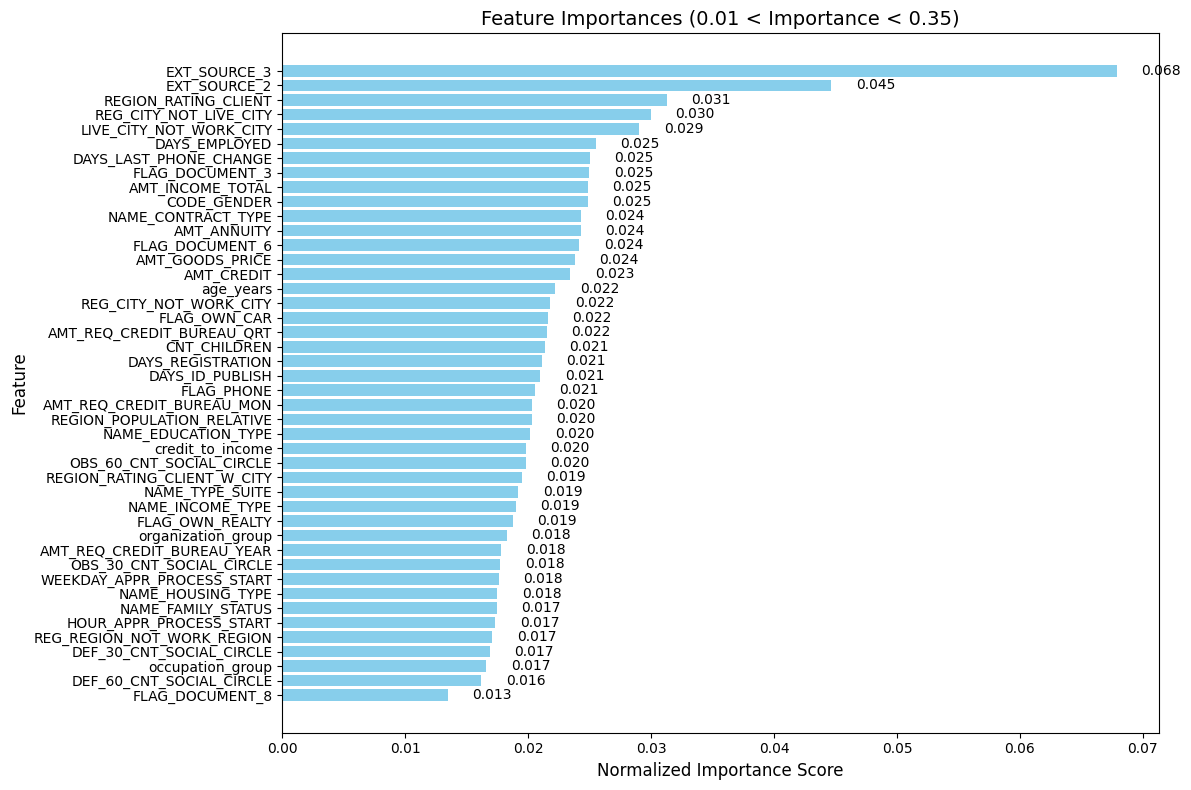

In [81]:
importances = best_xgb_model.feature_importances_
importances = importances / importances.sum()


importance_df = pd.DataFrame({
    'Feature': X_train_rf_xgb_lgb_cb.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)


filtered_importance = importance_df[
    (importance_df['Importance'] > 0.01) &  # 1% > kimi
    (importance_df['Importance'] < 0.35)
]

plt.figure(figsize=(12, 8))
bars = plt.barh(filtered_importance['Feature'], filtered_importance['Importance'], color='skyblue')
plt.title("Feature Importances (0.01 < Importance < 0.35)", fontsize=14)
plt.xlabel("Normalized Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.gca().invert_yaxis()

for i, (imp, feat) in enumerate(zip(filtered_importance['Importance'], filtered_importance['Feature'])):
    plt.text(imp + 0.002, i, f"{imp:.3f}", va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


In [82]:
importance_df.Feature.tolist()

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_INCOME_TOTAL',
 'CODE_GENDER',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'FLAG_DOCUMENT_6',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'age_years',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_OWN_CAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_CHILDREN',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'REGION_POPULATION_RELATIVE',
 'NAME_EDUCATION_TYPE',
 'credit_to_income',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'FLAG_OWN_REALTY',
 'organization_group',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'occupation_group',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'F

SHAP Values Summary (Selected Features)


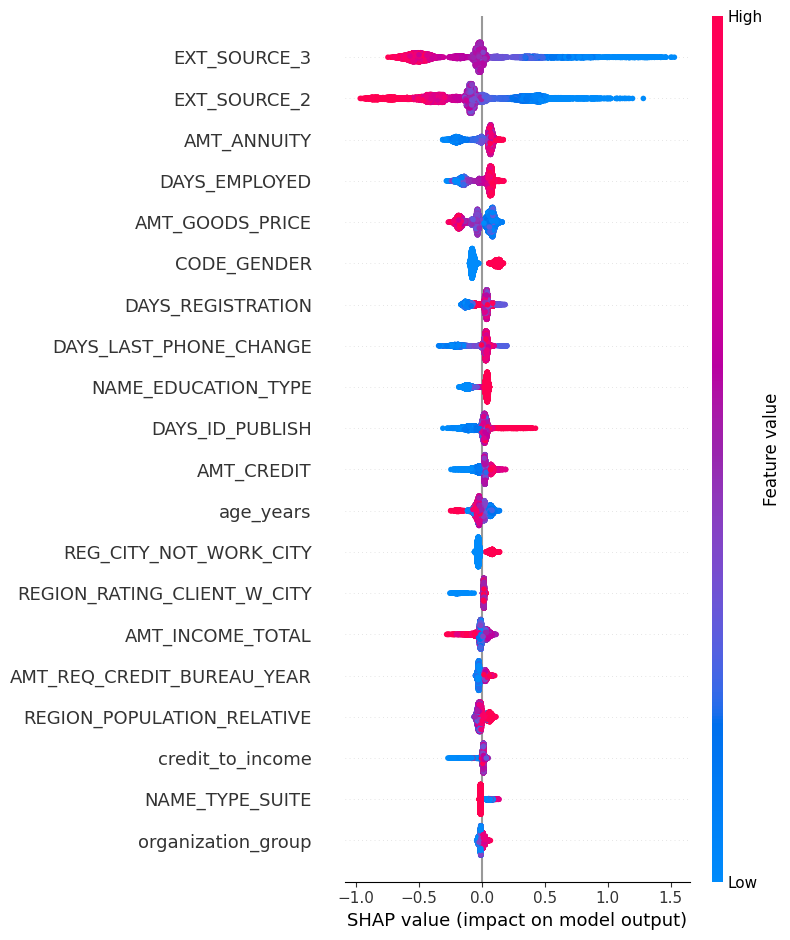

In [83]:

selected_features = [
'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_INCOME_TOTAL',
 'CODE_GENDER',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'FLAG_DOCUMENT_6',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'age_years',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_OWN_CAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_CHILDREN',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'REGION_POPULATION_RELATIVE',
 'NAME_EDUCATION_TYPE',
 'credit_to_income',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'FLAG_OWN_REALTY',
 'organization_group',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'occupation_group',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_8',
 'CNT_FAM_MEMBERS',
 'FLAG_EMAIL',
 'FLAG_WORK_PHONE',
 'FLAG_EMP_PHONE',
 'is_large_family',
 'is_single_parent'
]


explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_train_rf_xgb_lgb_cb)


shap_df = pd.DataFrame(shap_values, columns=X_train_rf_xgb_lgb_cb.columns)
shap_selected = shap_df[selected_features]
X_selected = X_train_rf_xgb_lgb_cb[selected_features]


print("SHAP Values Summary (Selected Features)")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_selected.values, X_selected, show=False)
plt.tight_layout()
plt.show()

In [84]:
selected_columns = [
'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'REGION_RATING_CLIENT',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DAYS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_INCOME_TOTAL',
 'CODE_GENDER',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'FLAG_DOCUMENT_6',
 'AMT_GOODS_PRICE',
 'AMT_CREDIT',
 'age_years',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_OWN_CAR',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'CNT_CHILDREN',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_PHONE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'REGION_POPULATION_RELATIVE',
 'NAME_EDUCATION_TYPE',
 'credit_to_income',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'FLAG_OWN_REALTY',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_HOUSING_TYPE',
 'NAME_FAMILY_STATUS',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_WORK_REGION',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'occupation_group',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_8',
 'CNT_FAM_MEMBERS',
 'FLAG_EMAIL',
 'FLAG_WORK_PHONE',
 'FLAG_EMP_PHONE',
 'is_large_family',
 'is_single_parent'
]

new_inputs_xgb = data_rf_xgb_lgb_cb[selected_columns]


In [87]:
X_train_xgb, X_test_xgb, y_train, y_test = train_test_split(new_inputs_xgb, output, test_size=0.2, random_state=42)

In [89]:
# XGBoost

def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 1, 10)
    }

    xgb_clf = XGBClassifier(**param)
    auc = cross_val_score(xgb_clf, X_train_xgb, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model_imp = XGBClassifier(**best_params)

[I 2025-11-06 21:03:37,744] A new study created in memory with name: no-name-0651495d-2038-40a0-b99c-54fc8ed37684
[I 2025-11-06 21:03:41,746] Trial 0 finished with value: 0.7156076668156237 and parameters: {'n_estimators': 420, 'learning_rate': 0.14078090548448097, 'max_depth': 9, 'subsample': 0.7609085012062977, 'colsample_bytree': 0.5412878092881604, 'gamma': 7}. Best is trial 0 with value: 0.7156076668156237.
[I 2025-11-06 21:03:44,556] Trial 1 finished with value: 0.7141917073071247 and parameters: {'n_estimators': 327, 'learning_rate': 0.04387074580984809, 'max_depth': 8, 'subsample': 0.6407692337299459, 'colsample_bytree': 0.57275740243972, 'gamma': 10}. Best is trial 0 with value: 0.7156076668156237.
[I 2025-11-06 21:03:46,800] Trial 2 finished with value: 0.7098714104155743 and parameters: {'n_estimators': 274, 'learning_rate': 0.1060110822857648, 'max_depth': 10, 'subsample': 0.7807448536375658, 'colsample_bytree': 0.5287491974348786, 'gamma': 9}. Best is trial 0 with value: 0

Best trial:
  Value: 0.721
  Params:  {'n_estimators': 380, 'learning_rate': 0.04421633669506484, 'max_depth': 3, 'subsample': 0.6691752644695755, 'colsample_bytree': 0.7083107043100103, 'gamma': 6}


In [91]:
train_and_evaluate_model('XGB opitimized for selected features', best_xgb_model_imp, X_train_xgb, y_train, X_test_xgb, y_test)

Model Performance for XGB opitimized for selected features
Train Gini prob is 60.48051816459987
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.88      0.03      0.06       680

    accuracy                           0.92      8227
   macro avg       0.90      0.52      0.51      8227
weighted avg       0.92      0.92      0.88      8227

[[7544    3]
 [ 658   22]]
Model Performance for XGB opitimized for selected features
Test Gini prob is 40.030020743947524
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.20      0.01      0.01       164

    accuracy                           0.92      2057
   macro avg       0.56      0.50      0.48      2057
weighted avg       0.86      0.92      0.88      2057

[[1889    4]
 [ 163    1]]


[0.6048051816459987, 0.40030020743947525]

In [92]:
#Voting

In [93]:
inputs_vot = data_knn.drop('TARGET', axis=1)

X_train, X_test, y_train, y_test = train_test_split(inputs_vot, output, test_size=0.2, random_state=42)

In [94]:
lr_model_vot = LogisticRegression()

In [95]:
# RF

def best_params_for_model(trial):
    param = {
    'n_estimators': trial.suggest_int('n_estimators', 10, 500), 
    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),  
    'max_depth': trial.suggest_int('max_depth', 10, 50),  
    'min_samples_split': trial.suggest_int('min_samples_split', 10, 200),  
    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),  
}

    rf_clf = RandomForestClassifier(**param)

    roc = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return roc

study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=50)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_rf_model_vot = RandomForestClassifier(**best_params)

[I 2025-11-06 21:06:53,562] A new study created in memory with name: no-name-f32fa189-1e1a-4719-ab33-4edf0021e8ce
[I 2025-11-06 21:06:56,684] Trial 0 finished with value: 0.6742409553844315 and parameters: {'n_estimators': 159, 'max_features': 'log2', 'max_depth': 22, 'min_samples_split': 193, 'min_samples_leaf': 34}. Best is trial 0 with value: 0.6742409553844315.
[I 2025-11-06 21:07:03,901] Trial 1 finished with value: 0.6771492264437012 and parameters: {'n_estimators': 377, 'max_features': 'sqrt', 'max_depth': 13, 'min_samples_split': 169, 'min_samples_leaf': 40}. Best is trial 1 with value: 0.6771492264437012.
[I 2025-11-06 21:07:07,387] Trial 2 finished with value: 0.6764320465984769 and parameters: {'n_estimators': 190, 'max_features': 'log2', 'max_depth': 25, 'min_samples_split': 101, 'min_samples_leaf': 27}. Best is trial 1 with value: 0.6771492264437012.
[I 2025-11-06 21:07:13,529] Trial 3 finished with value: 0.6786856874594531 and parameters: {'n_estimators': 379, 'max_featu

Best trial:
  Value: 0.681
  Params:  {'n_estimators': 276, 'max_features': 'sqrt', 'max_depth': 41, 'min_samples_split': 46, 'min_samples_leaf': 48}


In [96]:
# Catboost 

def best_params_for_model(trial):

    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10), 
         #'cat_features': [],
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss'])
    }

    cb_clf = CatBoostClassifier(**param)

    auc = cross_val_score(cb_clf, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=1)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_cb_model_vot = CatBoostClassifier(**best_params)

[I 2025-11-06 21:12:00,813] A new study created in memory with name: no-name-9677030e-6c7d-4e8b-ac84-3854d4a60a06
C:\Users\user\AppData\Local\Temp\ipykernel_25316\3396431457.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_25316\3396431457.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10),
[I 2025-11-06 21:12:10,375] Trial 0 finished with value: 0.6531924068905514 and parameters: {'iterations': 607, 'learning_rate': 0.015190470166445553, 'depth': 6, 'l2_leaf_reg': 0.12910480776046432, 'loss

Best trial:
  Value: 0.653
  Params:  {'iterations': 607, 'learning_rate': 0.015190470166445553, 'depth': 6, 'l2_leaf_reg': 0.12910480776046432, 'loss_function': 'Logloss'}


In [97]:
# XGBoost

def best_params_for_model(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_int('gamma', 1, 10)
    }

    xgb_clf = XGBClassifier(**param)
    auc = cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return auc



study = optuna.create_study(direction='maximize')
study.optimize(best_params_for_model, n_trials=10)

print('Best trial:')
best_params = study.best_params
print('  Value: {:.3f}'.format(study.best_value))
print('  Params: ', best_params)

best_xgb_model_vot = XGBClassifier(**best_params)

[I 2025-11-06 21:12:10,416] A new study created in memory with name: no-name-587e53ca-e77a-48f5-81e7-a5c4b6d25bf0
[I 2025-11-06 21:12:12,806] Trial 0 finished with value: 0.672591097358196 and parameters: {'n_estimators': 484, 'learning_rate': 0.0276549469278871, 'max_depth': 4, 'subsample': 0.754011745299337, 'colsample_bytree': 0.5980407350081937, 'gamma': 3}. Best is trial 0 with value: 0.672591097358196.
[I 2025-11-06 21:12:14,440] Trial 1 finished with value: 0.6725077127805819 and parameters: {'n_estimators': 469, 'learning_rate': 0.2710260355966349, 'max_depth': 3, 'subsample': 0.9825766563652933, 'colsample_bytree': 0.5108689227269769, 'gamma': 8}. Best is trial 0 with value: 0.672591097358196.
[I 2025-11-06 21:12:15,549] Trial 2 finished with value: 0.6323259320844186 and parameters: {'n_estimators': 257, 'learning_rate': 0.554838606962509, 'max_depth': 6, 'subsample': 0.6513484724708258, 'colsample_bytree': 0.6764088758554279, 'gamma': 8}. Best is trial 0 with value: 0.672591

Best trial:
  Value: 0.673
  Params:  {'n_estimators': 484, 'learning_rate': 0.0276549469278871, 'max_depth': 4, 'subsample': 0.754011745299337, 'colsample_bytree': 0.5980407350081937, 'gamma': 3}


In [98]:
voting_clf_hard = VotingClassifier(
    estimators=[
        ('lr', lr_model_vot),
        ('rf', best_rf_model_vot),
        ('xgb', best_xgb_model_vot),
        ('cat', best_cb_model_vot)
    ],
    voting='hard' 
)

In [99]:
def train_and_evaluate_model_voting_hard(model_name, model, X_train, y_train, X_test, y_test):
    try:
        print(f"\nTraining {model_name}...")
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_report_dict = classification_report(y_train, y_train_pred, output_dict=True)
        test_report_dict = classification_report(y_test, y_test_pred, output_dict=True)

        train_report_df = pd.DataFrame(train_report_dict).transpose()
        test_report_df = pd.DataFrame(test_report_dict).transpose()

        train_report_df["Dataset"] = "Train"
        train_report_df["Model"] = model_name

        test_report_df["Dataset"] = "Test"
        test_report_df["Model"] = model_name

        final_df = pd.concat([train_report_df, test_report_df], axis=0)

        return final_df

    except Exception as e:
        print(f"An error occurred while evaluating the model {model_name}: {e}")
        return None


In [100]:
train_and_evaluate_model_voting_hard('Voting model', voting_clf_hard, X_train, y_train, X_test, y_test)


Training Voting model...


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6775446	total: 11.7ms	remaining: 7.09s
1:	learn: 0.6625302	total: 22.3ms	remaining: 6.76s
2:	learn: 0.6477598	total: 32.3ms	remaining: 6.5s
3:	learn: 0.6335444	total: 43.1ms	remaining: 6.5s
4:	learn: 0.6203016	total: 55.3ms	remaining: 6.66s
5:	learn: 0.6069780	total: 65.9ms	remaining: 6.6s
6:	learn: 0.5945696	total: 76.3ms	remaining: 6.54s
7:	learn: 0.5827114	total: 86.5ms	remaining: 6.47s
8:	learn: 0.5712059	total: 97.4ms	remaining: 6.47s
9:	learn: 0.5602297	total: 108ms	remaining: 6.42s
10:	learn: 0.5496294	total: 118ms	remaining: 6.37s
11:	learn: 0.5394338	total: 128ms	remaining: 6.34s
12:	learn: 0.5296813	total: 139ms	remaining: 6.34s
13:	learn: 0.5202130	total: 149ms	remaining: 6.31s
14:	learn: 0.5110910	total: 159ms	remaining: 6.29s
15:	learn: 0.5019778	total: 170ms	remaining: 6.27s
16:	learn: 0.4930948	total: 180ms	remaining: 6.26s
17:	learn: 0.4845797	total: 191ms	remaining: 6.25s
18:	learn: 0.4768533	total: 201ms	remaining: 6.23s
19:	learn: 0.4693003	total: 212ms	r

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\sit

,precision,recall,f1-score,support,Dataset,Model
0.0,0.9173,1.0000,0.9569,7547.0000,Train,Voting model
1.0,0.0000,0.0000,0.0000,680.0000,Train,Voting model
accuracy,0.9173,0.9173,0.9173,0.9173,Train,Voting model
macro avg,0.4587,0.5000,0.4784,8227.0000,Train,Voting model
weighted avg,0.8415,0.9173,0.8778,8227.0000,Train,Voting model
0.0,0.9203,1.0000,0.9585,1893.0000,Test,Voting model
1.0,0.0000,0.0000,0.0000,164.0000,Test,Voting model
accuracy,0.9203,0.9203,0.9203,0.9203,Test,Voting model
macro avg,0.4601,0.5000,0.4792,2057.0000,Test,Voting model
weighted avg,0.8469,0.9203,0.8821,2057.0000,Test,Voting model


In [101]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ('lr', lr_model_vot),
        ('rf', best_rf_model_vot),
        ('xgb', best_xgb_model_vot),
        ('cat', best_cb_model_vot)
    ],
    voting='soft' 
)

train_and_evaluate_model('Voting model', voting_clf_soft, X_train, y_train, X_test, y_test)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0:	learn: 0.6775446	total: 10.8ms	remaining: 6.55s
1:	learn: 0.6625302	total: 20.3ms	remaining: 6.14s
2:	learn: 0.6477598	total: 30.3ms	remaining: 6.1s
3:	learn: 0.6335444	total: 40.9ms	remaining: 6.17s
4:	learn: 0.6203016	total: 52.2ms	remaining: 6.28s
5:	learn: 0.6069780	total: 62.1ms	remaining: 6.22s
6:	learn: 0.5945696	total: 72.8ms	remaining: 6.24s
7:	learn: 0.5827114	total: 82.3ms	remaining: 6.16s
8:	learn: 0.5712059	total: 93.5ms	remaining: 6.21s
9:	learn: 0.5602297	total: 103ms	remaining: 6.15s
10:	learn: 0.5496294	total: 114ms	remaining: 6.15s
11:	learn: 0.5394338	total: 124ms	remaining: 6.16s
12:	learn: 0.5296813	total: 134ms	remaining: 6.14s
13:	learn: 0.5202130	total: 145ms	remaining: 6.15s
14:	learn: 0.5110910	total: 156ms	remaining: 6.16s
15:	learn: 0.5019778	total: 167ms	remaining: 6.16s
16:	learn: 0.4930948	total: 178ms	remaining: 6.18s
17:	learn: 0.4845797	total: 189ms	remaining: 6.18s
18:	learn: 0.4768533	total: 199ms	remaining: 6.15s
19:	learn: 0.4693003	total: 208ms

C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Model Performance for Voting model
Train Gini prob is 78.02379597658596
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.00      0.00      0.00       680

    accuracy                           0.92      8227
   macro avg       0.46      0.50      0.48      8227
weighted avg       0.84      0.92      0.88      8227

[[7547    0]
 [ 680    0]]
Model Performance for Voting model
Test Gini prob is 34.17404300825893
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[0.7802379597658595, 0.34174043008258925]

In [102]:
# Stacking

In [103]:
estimators = [
    ('rf', best_rf_model_vot),
    ('xgb', best_xgb_model_vot),
    ('cat', best_cb_model_vot)
]

estimators

[('rf',
  RandomForestClassifier(max_depth=41, min_samples_leaf=48, min_samples_split=46,
                         n_estimators=276)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.5980407350081937, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=3, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.0276549469278871,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=484, n_jobs=None,
                num_parallel_tree=None, ...)),
 ('cat', <catboost.core.CatBoostCl

In [104]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=lr_model_vot,
    passthrough=True,   
    cv=5,                
    stack_method='predict_proba'  
)

stack_clf

,estimators,"[('rf', ...), ('xgb', ...), ...]"
,final_estimator,LogisticRegression()
,cv,5
,stack_method,'predict_proba'
,n_jobs,None
,passthrough,True
,verbose,0
,n_estimators,276
,criterion,'gini'
,max_depth,41
,min_samples_split,46


In [105]:
train_and_evaluate_model('Stacking model', stack_clf, X_train, y_train, X_test, y_test)

0:	learn: 0.6775446	total: 9.7ms	remaining: 5.88s
1:	learn: 0.6625302	total: 19.1ms	remaining: 5.76s
2:	learn: 0.6477598	total: 29.4ms	remaining: 5.93s
3:	learn: 0.6335444	total: 38.8ms	remaining: 5.84s
4:	learn: 0.6203016	total: 48.2ms	remaining: 5.81s
5:	learn: 0.6069780	total: 57.1ms	remaining: 5.72s
6:	learn: 0.5945696	total: 66.8ms	remaining: 5.72s
7:	learn: 0.5827114	total: 75.8ms	remaining: 5.68s
8:	learn: 0.5712059	total: 86.2ms	remaining: 5.73s
9:	learn: 0.5602297	total: 97.1ms	remaining: 5.8s
10:	learn: 0.5496294	total: 108ms	remaining: 5.83s
11:	learn: 0.5394338	total: 118ms	remaining: 5.83s
12:	learn: 0.5296813	total: 128ms	remaining: 5.83s
13:	learn: 0.5202130	total: 138ms	remaining: 5.84s
14:	learn: 0.5110910	total: 148ms	remaining: 5.83s
15:	learn: 0.5019778	total: 157ms	remaining: 5.81s
16:	learn: 0.4930948	total: 167ms	remaining: 5.81s
17:	learn: 0.4845797	total: 179ms	remaining: 5.84s
18:	learn: 0.4768533	total: 188ms	remaining: 5.81s
19:	learn: 0.4693003	total: 198ms

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: Undefin

Model Performance for Stacking model
Train Gini prob is 17.562568687207225
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      7547
         1.0       0.00      0.00      0.00       680

    accuracy                           0.92      8227
   macro avg       0.46      0.50      0.48      8227
weighted avg       0.84      0.92      0.88      8227

[[7547    0]
 [ 680    0]]
Model Performance for Stacking model
Test Gini prob is 15.525749552265733
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1893
         1.0       0.00      0.00      0.00       164

    accuracy                           0.92      2057
   macro avg       0.46      0.50      0.48      2057
weighted avg       0.85      0.92      0.88      2057

[[1893    0]
 [ 164    0]]


C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[0.17562568687207225, 0.15525749552265733]